# Protokoll zum Thema "Analyse der Stilografie bei Jameda Arzt Bewertungen"
### von Huy Duc Hoa (Matr.-Nr.: 1328754) und Hannes Dreyer (Matr.-Nr.: 1193059)

# Inhaltverzeichnis

- [Laden der erforderlichen Datensätze](#Laden-der-erforderlichen-Datens%C3%A4tze)
- [Datenqualität](#Datenqualit%C3%A4t)
    - [Datenbereinigung](#Datenbereinigung)
    - [Datenwiederherstellung](#Datenwiederherstellung)
    - [Datenaufbereitung anderer Datensätze](#Datenaufbereitung-anderer-Datens%C3%A4tze)
- [Datenanalyse](#Datenanalyse)
  - [Absätze](#Anzahl-verwendeter-Abs%C3%A4tze-im-Verh%C3%A4ltnis-zur-L%C3%A4nge-des-Textes)
  - [Verwendung von Satzzeichen](#Satzzeichen-(SpaCy))
  - [Rechtschreibung](#Rechtschreibkorrektur)
    - [Transformer](#Rechtschreibkorrektur)
    - [SpellChecker](#Spellchecker)
    - [Enchant](#Enchant)
  - [Text-Länge](#Text-L%C3%A4nge)
  - [Anzahl Großbuchstaben](#Anzahl-Gro%C3%9Fbuchstaben)
- [Weiterführende Ideen](#Weiterf%C3%BChrende-Ideen)
- [Fazit / Learnings](#Fazit-/-Learnings)

# Anmerkung
Das Protokoll wurde aus zwei Dokumenten zusammengefügt. Im Folgenden kann es deswegen dazu kommen, dass gleiche Entitäten/ Datenstrukturen unterschiedliche Variablen/ Bezeichnungen haben können. Diese sind aber immer in den dazugehörigen Textelementen entsprechend gekennzeichnet.

Zudem gibt es noch zwei Probleme mit den Daten, die zu Ungenauigkeiten der Analysen führen können. Erstens wäre dies, dass der Autor der Bewertung, dessen Schreibstil analysiert werden soll, nicht zwangsweise die behandelte Person ist. Da zu jeder Bewertung allerdings bspw. das Alter des Patienten angegeben wird, kann dies zu Ungenauigkeiten führen. Beispielsweise kann ein junger Mensch eine ältere, familienangehörige Person zum Arzt begleitet haben und daraufhin eine Bewertung über die Erfahrung vor Ort geschrieben haben. Nun wird diese Bewertung in den folgenden Auswertungen aber so behandelt, als würde sie von der älteren Person geschrieben worden sein. Da dies allerdings nicht auf einfachem Wege herausgefiltert werden kann, werden diese Fehler in den Analysen hingenommen.

Ein ähnliches Problem kann auch mit den Auswertungen basierend auf der Region auftreten. Hier wird die PLZ bzw. der Name der Stadt, wo der Arzt ansässig ist, als Kriterium genommen. Die Auswertungen beruhen somit auf der Annahme, dass der Großteil der Patienten auch in der Nähe des Arztes, den er aufsucht, wohnt und lebt.

## Fragestellung
Mittlerweile lässt sich sagen, dass fast alle Bevölkerungsgruppen Bewertungen im Internet schreiben. Daraus ableitend haben wir uns folgende Frage gestellt:

**Lassen sich unter Betrachtung bestimmter Kategorisierungen klare Tendenzen hinsichtlich des Schreibstils in den Jameda-Bewertungstexten erkennen?**


## Ablauf:
Für die Bearbeitung der Fragestellung wurde sich an dem ETL (**E**xtract, **T**ransform,**L**oad)- Ansatzes orientiert.
Die *Extract*-Phase umfasst in diesem Kontext das **Laden der erforderlichen Datensätze** in die Entwicklungsumgebung, da die erforderlichen Datensätze uns dabei zur Verfügung gestellt wurden.
In der *Transform*-Phase wurden diese **Datensätze bereinigt, analysiert und ausgewertet**. Basierend auf diesen Auswertungen wurden **entsprechende Schlussfolgerungen** und ein **abschließendes Fazit gezogen**.

## Laden der erforderlichen Datensätze
Die erforderlichen Datensätze wurden von Herrn Bäumer im ILIAS zur Vefügung gestellt. Die Datensätze waren:
- "jameda-arzt.json" im Folgenden "arzt" genannt, wo alle Ärzte aufgelistet sind.
- "fachgebiet.json" im Folgenden "fachgebiet" genannt, wo alle Fachgebiete aufgelistet sind,
- "arzt_fachgebiet.json" im Folgenden "arzt_fachgebiet" genannt, welches eine Übersicht darüber gibt welche Ärzte welche Fachgebiete abdecken
- "jameda_bewertung.json" im Folgenden "bewertung" genannt, welche alle Jameda Bewertungen für den Zeitraum 2014-2018 enthält

Die Analyse und Auswertung der Datensätze erfolgte mithilfe der aufgelisteten Python Bibliotheken, die in die Entwicklungsumgebung importiert wurden.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from spellchecker import SpellChecker
import enchant
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from germansentiment import SentimentModel

Um diese Datensätze bearbeiten zu können, wurden diese wie folgt in die Entwicklungsumgebung geladen:

In [2]:
arzt_fachgebiet=pd.read_json("arzt_fachgebiet.json")
fachgebiet=pd.read_json("fachgebiet.json")
arzt=pd.read_json("jameda-arzt.json")
bewertung=pd.read_json("jameda-bewertung.json")

Anschließend wird ein Überblick über die Datensätze verschafft, indem von jedem Datensatz ein zufälliger Ausschnitt von jeweils 5 Elementen ausgegeben wird.


In [3]:
arzt_fachgebiet.sample(5)

,arzt_id,fachgebiet_id,top,top_stand
134777,80119016,150,0,None
231057,80295102,1,0,None
457914,81105674,23,0,None
68655,80068294,433,0,None
641559,81363713,11011,0,None


In [4]:
fachgebiet.sample(5)

,id,name
167,12341,Immunologie
172,16160,Fachzahnärztin für Kieferorthopädie
179,30391,Pharmakologie & Toxikologie
233,177588,Geburtshelfer
216,93963,Tierarzt für Geflügel


In [5]:
arzt.sample(5)

,id,letzte_datensatz_anpassung,vorname,nachname,geschlecht_id,profilbildlink,plz,stadt,straße,straßennummer,...,premium_id,unauffaellige_bewertungen,letztes_profil_update,anzahl_empfehlungen_patient,anzahl_empfehlungen_arzt,prozent_weiterempfehlung,anzahl_profilaufrufe,onlinetermin,videosprechstunde,klinikarzt
193668,81011941,2018-05-28 23:31:08,Tobias,Walter,1.0,None,51399.0,Burscheid,Montanusstraße,3,...,0,0,2016-10-06,98,0,100.0,11462,0,0,0
89879,80235603,2018-05-17 22:07:50,Götz,Braumandl,1.0,None,93152.0,Nittendorf,Am Marktplatz,5,...,0,1,2008-11-03,22,0,100.0,4020,0,0,0
301744,81225806,2018-04-16 15:37:32,Susann,Gleißner,2.0,None,19063.0,Schwerin,Am Hang,32,...,0,0,2011-07-13,1,0,NaN,778,0,0,0
292457,81207001,2018-04-12 12:32:58,Christian,Heinitz,1.0,None,24534.0,Neumünster,Großflecken,26,...,0,0,2015-11-17,158,0,54.0,9097,0,0,0
185427,80427738,2018-03-17 22:24:36,Horst,Meruna,1.0,None,32545.0,Bad Oeynhausen,Am Brinkkamp,16,...,0,0,2013-11-12,9,0,NaN,1732,0,0,1


In [5]:
bewertung.sample(5)

,letzte_datensatz_anpassung,id,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,anonym_fragen,alter_min,alter_max,versicherung,hilfreich_prozent,hilfreich_stimmen,ohne_note,ohne_text,archiviert,note_oeffnungszeiten
623218,2018-04-16 21:11:33,1439917,81233709,0,4,2014-06-05,0,Top Arzt,Immer freundlich und kompetent. Läßt sich Zeit...,Immer freundlich und kompetent. Läßt sich Zeit...,...,1.0,51.0,999.0,1.0,NaN,NaN,0,0,0,NaN
1655516,2018-05-13 17:17:38,3362960,80064171,0,18,2017-05-04,0,Multifokalen Linsenaustausch,Am 11.04.2017 bekam ich durch Herrn Dr. Kromme...,Am 11.04.2017 bekam ich durch Herrn Dr. Kromme...,...,1.0,51.0,999.0,1.0,100.0,1.0,0,0,0,NaN
1131234,2018-04-16 12:15:34,2467976,81093737,0,54,2016-01-11,0,"Sehr netter, im Umgang mit Patienten angenehm ...",Herr Prof. Dr. Thomas Kalteis hat bei mir 2014...,Herr Prof. Dr. Thomas Kalteis hat bei mir 2014...,...,1.0,51.0,999.0,2.0,NaN,NaN,0,0,0,NaN
1472803,2018-05-03 11:55:30,3053175,81443555,0,12,2016-11-24,0,Eine ausgezeichnete Ärztin,Fr. Dr. Lu nimmt sich die Zeit um Fragen ausfü...,Fr. Dr. Lu nimmt sich die Zeit um Fragen ausfü...,...,1.0,51.0,999.0,1.0,100.0,1.0,0,0,0,NaN
509647,2018-05-13 14:03:34,1207553,80056824,0,14,2014-01-09,0,Sehr liebenswerte Ärztin...,...mit der man auch lachen kann. Sehr nette un...,...mit der man auch lachen kann. Sehr nette un...,...,1.0,NaN,NaN,NaN,NaN,NaN,0,0,1,NaN


## Datenqualität
Ein wichtiges Fundament für eine Datenanalyse, sind die Daten, auf der sie beruht. Aus diesem Grund ist es wichtig,  diese für die Analyse entsprechend aufzubereiten. Diese Aufbereitung decken wir durch die *Bereinigung* und *Wiederherstellung* der Daten ab.

### Datenbereinigung
In der Datenbereinigung ist es wichtig darauf zu achten, dass die Daten richtig formatiert sind und keine unnötigen Duplikate existieren.

#### Datenformatierung

Für die Identifizierung von falsch formatierten Daten, geben wir für jeden Datensatz eine Übersicht mit allen Spalten und dem Datenformat aus.

In [6]:
arzt_fachgebiet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759869 entries, 0 to 759868
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   arzt_id        759869 non-null  int64 
 1   fachgebiet_id  759869 non-null  int64 
 2   top            759869 non-null  int64 
 3   top_stand      10471 non-null   object
dtypes: int64(3), object(1)
memory usage: 23.2+ MB


In [8]:
fachgebiet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      293 non-null    int64 
 1   name    293 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.7+ KB


In [9]:
arzt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413218 entries, 0 to 413217
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           413218 non-null  int64  
 1   letzte_datensatz_anpassung   413218 non-null  object 
 2   vorname                      413218 non-null  object 
 3   nachname                     413218 non-null  object 
 4   geschlecht_id                403814 non-null  float64
 5   profilbildlink               12908 non-null   object 
 6   plz                          413060 non-null  float64
 7   stadt                        413060 non-null  object 
 8   straße                       413053 non-null  object 
 9   straßennummer                412054 non-null  object 
 10  lat                          412477 non-null  float64
 11  lng                          412477 non-null  float64
 12  einrichtung_id               193534 non-null  float64
 13 

In [10]:
bewertung.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056615 entries, 0 to 2056614
Data columns (total 43 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   letzte_datensatz_anpassung      object 
 1   id                              int64  
 2   arzt_id                         int64  
 3   seite                           int64  
 4   seite_pos                       int64  
 5   datum                           object 
 6   blockiert                       int64  
 7   titel                           object 
 8   teaser                          object 
 9   text                            object 
 10  kommentar                       object 
 11  note_gesamt                     float64
 12  note_behandlung                 float64
 13  note_engagement                 float64
 14  note_diskretion                 float64
 15  note_aufklaerung                float64
 16  note_vertrauensverhaeltnis      float64
 17  note_eingehenbelange       

Bei der Betrachtung der Tabellen fällt auf, dass die Postleitzahl im Datensatz *arzt* als Integer formatiert ist. Auffällig ist außerdem, dass in den Übersichten der Spalte *Non-Null Count*, die Werte nicht identisch sind. Dies deutet darauf hin, dass es in einigen Spalten von Datensätzen Daten fehlen/nicht vorhanden sind. Auf diese Problematik wird im Abschnitt Datenwiederherstellung näher darauf eingegangen.

#### Formatierung der Spalte *arzt["plz"]*
 Um die Spalte richtig zu formatieren, reichte es nicht aus, den Datentyp der Spalte von Integer auf String zu ändern. Um ein richtiges, strukturiertes Vorgehen zu entwickeln, werden sich die Elemente in der Spalte angeschaut.

In [11]:
arzt.plz.unique()

array([88175., 91522., 29614., ..., 86574., 93191., 88718.])

Beim Durchgehen der Werte fallen zwei Dinge auf:
- Einige Werte sind Vierstellig und andere Werte wiederum Fünfstellig sind. Diese Diskrepanz kommt höchstwahrscheinlich dadurch zustande, dass bei Integer die Nullen an vorderster Stelle nicht berücksichtigt werden und legt nahe, dass die vierstelligen Zahlen mit einer Null an erster Stelle ergänzt werden müssen.
- Jeder Wert hat ein Komma mit einer Null, für die korrekte Darstellung von Postleitzahlen gilt es diese zu entfernen.

Um grundsätzlich die Möglichkeit zu bewahren, weiterhin Zugriff auf originalen Datensätze zu haben, werden für Veränderungen am Datensatz separate Kopien der Datensätze erstellt. Dieses Vorgehen wird auch im Folgenden immer wieder angewendet, sobald die Datensätze verändert werden sollen.

In [12]:
arzt_v1=arzt

Nachdem die Kopie erstellt wurde, wird im ersten Schritt der Datentyp von Integer in den Datentyp String formatiert. Um das Risiko vom möglichem Informationsverlust zu umgehen, wird diese Veränderung als neue Spalte *plz_str* ausgegeben. Auch dieses Vorgehen wird im Folgenden immer wieder angewendet, wenn die Werte von Spalten verändert werden sollen.

In [13]:
arzt_v1["plz_str"]=arzt_v1["plz"].astype("str")
arzt_v1["plz_str"]

0         88175.0
1         91522.0
2         29614.0
3         70174.0
4         70374.0
           ...   
413213    48301.0
413214    64683.0
413215    18182.0
413216    64686.0
413217    18119.0
Name: plz_str, Length: 413218, dtype: object

Im nächsten Schritt wird aus den Postleitzahlen das *.0* entfernt. Hierfür werden alle aus den Strings alle Zahlen bis zum "." extrahiert und in einer separaten Spalte *plz_str_ohne_komma* ausgegeben.

In [14]:
arzt_v1["plz_str_ohne_komma"]=arzt_v1["plz_str"].str.extract("([0-9]+).")
arzt_v1["plz_str_ohne_komma"]

0         88175
1         91522
2         29614
3         70174
4         70374
          ...  
413213    48301
413214    64683
413215    18182
413216    64686
413217    18119
Name: plz_str_ohne_komma, Length: 413218, dtype: object

Im letzten Schritt soll die vierstelligen Postleitzahlen mit einer Null an erster Stelle ergänzt werden. Hierfür wird die String Länge in einer separaten Spalte abgespeichert.

In [15]:
arzt_v1["plz_str_ohne_komma_len"]=arzt_v1["plz_str_ohne_komma"].str.len()
arzt_v1[["plz_str_ohne_komma_len","plz_str_ohne_komma"]]

,plz_str_ohne_komma_len,plz_str_ohne_komma
0,5.0,88175
1,5.0,91522
2,5.0,29614
3,5.0,70174
4,5.0,70374
...,...,...
413213,5.0,48301
413214,5.0,64683
413215,5.0,18182
413216,5.0,64686


Anschließend werden alle Werte, deren String Länge kleiner fünf ist, mit einer 0 an erster Stelle ergänzt. Die restlichen Werte, welche die Bedingung nicht erfüllen, bleiben unberührt.

In [16]:
arzt_v1["postleitzahl"]=np.where(arzt_v1["plz_str_ohne_komma_len"]<5,"0"+arzt_v1["plz_str_ohne_komma"],arzt_v1["plz_str_ohne_komma"] )
arzt_v1["postleitzahl"]

0         88175
1         91522
2         29614
3         70174
4         70374
          ...  
413213    48301
413214    64683
413215    18182
413216    64686
413217    18119
Name: postleitzahl, Length: 413218, dtype: object

Zur optischen Verfeinerung wird vom Datensatz *arzt_v1* eine Version *arzt_v2* erstellt, wo die Spalte *plz* durch die neuformatierte Spalte *postleitzahl* ersetzt wurde und die für Formatierung benötigten Spalten nicht berücksicht werden.

In [17]:
arzt_v2=arzt_v1[['id', 'letzte_datensatz_anpassung', 'vorname', 'nachname',
                 'geschlecht_id', 'profilbildlink', 'postleitzahl', 'stadt', 'straße',
                 'straßennummer', 'lat', 'lng', 'einrichtung_id', 'webseite', 'telefon',
                 'patient_kasse', 'patient_privat', 'premium_id',
                 'unauffaellige_bewertungen', 'letztes_profil_update',
                 'anzahl_empfehlungen_patient', 'anzahl_empfehlungen_arzt',
                 'prozent_weiterempfehlung', 'anzahl_profilaufrufe', 'onlinetermin',
                 'videosprechstunde', 'klinikarzt' ]]
arzt_v2.sample(5)

,id,letzte_datensatz_anpassung,vorname,nachname,geschlecht_id,profilbildlink,postleitzahl,stadt,straße,straßennummer,...,premium_id,unauffaellige_bewertungen,letztes_profil_update,anzahl_empfehlungen_patient,anzahl_empfehlungen_arzt,prozent_weiterempfehlung,anzahl_profilaufrufe,onlinetermin,videosprechstunde,klinikarzt
138725,80334720,2018-03-18 14:06:18,Theo,Breidbach,1.0,None,56072,Koblenz,Oberweiher,4,...,0,1,2015-10-20,55,0,43.0,12109,0,0,0
379152,81440070,2018-05-03 21:42:08,Michael,Steinbach,1.0,None,50674,Köln,Zülpicher Platz,12,...,0,0,2016-06-14,0,0,NaN,80,0,0,0
156640,80368411,2018-03-13 20:54:03,Lutz,Schwäbisch,1.0,None,20359,Hamburg,Budapester Str.,28,...,0,0,2008-09-02,0,0,NaN,944,0,0,0
107540,80283308,2018-05-22 09:10:15,Oliver,Harney,1.0,None,74321,Bietigheim-Bissingen,Flößerstraße,60,...,0,1,2017-02-21,60,0,77.0,12740,0,0,0
91392,80239628,2018-05-17 23:42:15,Bernd,Iffland,1.0,None,07426,Königsee-Rottenbach,Rudolstädter Str.,47,...,0,1,2013-05-08,14,0,NaN,4850,0,0,0


#### Duplikate

Um die unnötigen Duplikate zu identifizieren, geben wir für jeden Datensatz eine Übersicht mit allen ihren Spalten mit der Anzahl der darin enthaltenen Duplikate aus.

In [18]:
arzt_fachgebiet.apply(pd.Series.duplicated).sum()

arzt_id          346666
fachgebiet_id    759576
top              759866
top_stand        759867
dtype: int64

In [19]:
fachgebiet.apply(pd.Series.duplicated).sum()

id      0
name    0
dtype: int64

In [20]:
arzt_v2.apply(pd.Series.duplicated).sum()

id                                  0
letzte_datensatz_anpassung         89
vorname                        382749
nachname                       287239
geschlecht_id                  413215
profilbildlink                 400473
postleitzahl                   405383
stadt                          405245
straße                         356283
straßennummer                  409707
lat                            353697
lng                            274104
einrichtung_id                 348201
webseite                       403080
telefon                        161797
patient_kasse                  413216
patient_privat                 413216
premium_id                     413215
unauffaellige_bewertungen      413216
letztes_profil_update          410523
anzahl_empfehlungen_patient    412311
anzahl_empfehlungen_arzt       413195
prozent_weiterempfehlung       413118
anzahl_profilaufrufe           385968
onlinetermin                   413216
videosprechstunde              413216
klinikarzt  

In [21]:
bewertung.apply(pd.Series.duplicated).sum()

letzte_datensatz_anpassung        1843770
id                                    493
arzt_id                           1857188
seite                             2056607
seite_pos                         2056515
datum                             2052773
blockiert                         2056613
titel                              920414
teaser                             109809
text                               109076
kommentar                         2011405
note_gesamt                       2056583
note_behandlung                   2056608
note_engagement                   2056608
note_diskretion                   2056608
note_aufklaerung                  2056608
note_vertrauensverhaeltnis        2056608
note_eingehenbelange              2056608
note_genommenezeit                2056608
note_freundlichkeit               2056608
note_angstpatienten               2056608
note_wartezeittermin              2056608
note_wartezeitpraxis              2056608
note_sprechstundenzeiten          

Bei Untersuchung der Übersicht fällt auf, dass die *id*-Spalte aus dem Datensatz *bewertung* Duplikate enthält. Da diese Spalte als Unique Identifier für die Bewertungen vorgesehen ist, sollten in dieser Spalte keine Duplikate existieren.

#### Untersuchung der Duplikate in *bewertung["id"]*
Die Ursachen für diese Duplikate untersuchen wir stichprobenartig an fünf Elementen etwas genauer. Hierfür geben wir fünf zufällige Bewertungen aus, wo in der Spalte *id* die Eigenschaft *dupliziert* wahr ist.

In [22]:
bewertung.loc[(bewertung.id.duplicated()==True)].sample(5)

,letzte_datensatz_anpassung,id,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,anonym_fragen,alter_min,alter_max,versicherung,hilfreich_prozent,hilfreich_stimmen,ohne_note,ohne_text,archiviert,note_oeffnungszeiten
1367477,2018-03-21 23:07:21,2874993,81382922,0,3,2016-08-18,0,"Freundlich, kompetent und nimmt sich Zeit",Frau Dr. Hoffmann ist eine freundliche und kom...,Frau Dr. Hoffmann ist eine freundliche und kom...,...,1.0,30.0,50.0,NaN,100.0,1.0,0,0,0,NaN
1240699,2018-05-10 13:30:21,2659368,81516025,0,15,2016-04-20,0,Kompetenter und netter Arzt,"Ein sehr kompetenter und netter Arzt......""",Ein sehr kompetenter und netter Arzt......,...,1.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
1160393,2018-05-22 06:56:53,2520307,81381033,0,39,2016-02-09,0,"ausgesprochen kompetent, geht auf Patienten ein","Handgelenksspiegelung, rechts. Verwachsungen d...","Handgelenksspiegelung, rechts. Verwachsungen d...",...,0.0,51.0,999.0,2.0,100.0,1.0,0,0,0,NaN
304304,2018-05-10 13:30:21,780608,81516025,0,50,2013-01-21,0,Kompetenter und sehr sympathischer Arzt,Ich bin schon seit Jahren bei Dr. Boos. Er ist...,Ich bin schon seit Jahren bei Dr. Boos. Er ist...,...,1.0,NaN,NaN,NaN,NaN,NaN,0,0,1,NaN
723709,2018-05-22 07:04:21,1637415,81187764,0,27,2014-10-13,0,"Genau, wie ich es wollte",Dr. Klesper hat meine Erwartungen mehr als übe...,Dr. Klesper hat meine Erwartungen mehr als übe...,...,1.0,NaN,NaN,NaN,100.0,1.0,0,0,0,NaN


In [23]:
bewertung.query("id==24490")

,letzte_datensatz_anpassung,id,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,anonym_fragen,alter_min,alter_max,versicherung,hilfreich_prozent,hilfreich_stimmen,ohne_note,ohne_text,archiviert,note_oeffnungszeiten
8421,2018-05-17 10:55:26,24490,80136751,0,56,2009-06-22,0,Bewertung vom 22. Juni,None,None,...,1.0,NaN,NaN,NaN,89.0,7.0,0,1,1,NaN
8422,2018-04-12 19:37:16,24490,81213064,0,56,2009-06-22,0,Bewertung vom 22. Juni,None,None,...,1.0,NaN,NaN,NaN,89.0,7.0,0,1,1,NaN


In [24]:
bewertung.query("id==1675268")

,letzte_datensatz_anpassung,id,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,anonym_fragen,alter_min,alter_max,versicherung,hilfreich_prozent,hilfreich_stimmen,ohne_note,ohne_text,archiviert,note_oeffnungszeiten
743135,2018-05-18 00:45:08,1675268,80243768,0,9,2014-11-04,0,Beide Ärztinnen empfehlenswert! Schwestern jed...,Unfreundliche und launische Schwestern. Kommen...,Unfreundliche und launische Schwestern. Kommen...,...,1.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
743136,2018-03-12 10:25:02,1675268,81300268,0,8,2014-11-04,0,Beide Ärztinnen empfehlenswert! Schwestern jed...,Unfreundliche und launische Schwestern. Kommen...,Unfreundliche und launische Schwestern. Kommen...,...,1.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN


In [25]:
bewertung.query("id==1513969")

,letzte_datensatz_anpassung,id,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,anonym_fragen,alter_min,alter_max,versicherung,hilfreich_prozent,hilfreich_stimmen,ohne_note,ohne_text,archiviert,note_oeffnungszeiten
660936,2018-03-12 15:36:22,1513969,80240837,0,3,2014-07-26,0,ganz liebe und kompetente Ärztin!!,"bei meiner Bewertung tat sich ein Fenster auf,...","bei meiner Bewertung tat sich ein Fenster auf,...",...,1.0,51.0,999.0,1.0,NaN,NaN,0,0,0,NaN
660937,2018-05-07 07:46:15,1513969,81494080,0,4,2014-07-26,0,ganz liebe und kompetente Ärztin!!,"bei meiner Bewertung tat sich ein Fenster auf,...","bei meiner Bewertung tat sich ein Fenster auf,...",...,1.0,51.0,999.0,1.0,NaN,NaN,0,0,0,NaN


In [26]:
bewertung.query("id==3100340")

,letzte_datensatz_anpassung,id,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,anonym_fragen,alter_min,alter_max,versicherung,hilfreich_prozent,hilfreich_stimmen,ohne_note,ohne_text,archiviert,note_oeffnungszeiten
1501509,2018-03-28 19:53:01,3100340,80263362,0,19,2016-12-19,0,2 OP's - 2 x super! Danke Dr. Hörl,Im Juni 2015 hatte ich eine beidseitige Lidkor...,Im Juni 2015 hatte ich eine beidseitige Lidkor...,...,1.0,51.0,999.0,2.0,NaN,NaN,0,0,0,NaN
1501510,2018-05-18 13:08:12,3100340,81446368,0,20,2016-12-19,0,2 OP's - 2 x super! Danke Dr. Hörl,Im Juni 2015 hatte ich eine beidseitige Lidkor...,Im Juni 2015 hatte ich eine beidseitige Lidkor...,...,1.0,51.0,999.0,2.0,NaN,NaN,0,0,0,NaN


In [27]:
bewertung.query("id==3081326")

,letzte_datensatz_anpassung,id,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,anonym_fragen,alter_min,alter_max,versicherung,hilfreich_prozent,hilfreich_stimmen,ohne_note,ohne_text,archiviert,note_oeffnungszeiten
1489790,2018-03-28 19:53:01,3081326,80263362,0,20,2016-12-09,0,Bruststraffung,"Ich bin mit meinem Ergebnis, sehr zu frieden u...","Ich bin mit meinem Ergebnis, sehr zu frieden u...",...,1.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
1489791,2018-05-18 13:08:12,3081326,81446368,0,21,2016-12-09,0,Bruststraffung,"Ich bin mit meinem Ergebnis, sehr zu frieden u...","Ich bin mit meinem Ergebnis, sehr zu frieden u...",...,1.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN


Beim Untersuchen der Duplikate fällt auf, dass bei den relevanten Spalten alle Elemente gleichgeblieben sind. Eine Ausnahme bildet die Spalte *arzt_id*. In fünf von fünf Fällen unterscheidet sich die duplizierte Bewertung ausschließlich in der *arzt_id*. Um eine Erklärung dafür zu finden, warum dies der Fall ist, verwenden wir den Datensatz *arzt* und untersuchen die *id's* der Ärzte.

In [28]:
arzt_v2.loc[(arzt_v2.id==80136751) | (arzt_v2.id==81213064)] #zu bewertung["id"]==24490

,id,letzte_datensatz_anpassung,vorname,nachname,geschlecht_id,profilbildlink,postleitzahl,stadt,straße,straßennummer,...,premium_id,unauffaellige_bewertungen,letztes_profil_update,anzahl_empfehlungen_patient,anzahl_empfehlungen_arzt,prozent_weiterempfehlung,anzahl_profilaufrufe,onlinetermin,videosprechstunde,klinikarzt
78611,80136751,2018-05-17 10:55:24,Ulrich,Tappe,NaN,bild1472811566360,59073,Hamm,Am Heessener Wald,1,...,2,0,2018-05-08,316,1,82.0,86032,0,0,0
295494,81213064,2018-04-12 19:37:12,Ulrich,Tappe,NaN,bild1472811566360,59065,Hamm,Sudetenweg,6,...,2,0,2018-04-09,316,1,82.0,85633,0,0,0


In [29]:
arzt_v2.loc[(arzt_v2.id==80243768) | (arzt_v2.id==81300268)] #zu bewertung["id"]==1675268

,id,letzte_datensatz_anpassung,vorname,nachname,geschlecht_id,profilbildlink,postleitzahl,stadt,straße,straßennummer,...,premium_id,unauffaellige_bewertungen,letztes_profil_update,anzahl_empfehlungen_patient,anzahl_empfehlungen_arzt,prozent_weiterempfehlung,anzahl_profilaufrufe,onlinetermin,videosprechstunde,klinikarzt
93613,80243768,2018-05-18 00:45:04,Martina,Vogel,2.0,None,18107,Rostock,Warnowallee,31,...,0,0,2018-04-18,38,0,73.0,6661,0,0,0
318522,81300268,2018-03-12 10:24:58,Martina,Vogel,2.0,None,18107,Rostock,Warnowallee,31,...,0,0,2016-03-09,36,0,73.0,6348,0,0,0


In [30]:
arzt_v2.loc[(arzt_v2.id==80240837) | (arzt_v2.id==81494080)] #zu bewertung["id"]==1513969

,id,letzte_datensatz_anpassung,vorname,nachname,geschlecht_id,profilbildlink,postleitzahl,stadt,straße,straßennummer,...,premium_id,unauffaellige_bewertungen,letztes_profil_update,anzahl_empfehlungen_patient,anzahl_empfehlungen_arzt,prozent_weiterempfehlung,anzahl_profilaufrufe,onlinetermin,videosprechstunde,klinikarzt
91908,80240837,2018-03-12 15:36:17,Astrid,Ritzau-Jost,2.0,None,99189,Walschleben,Erfurter Str.,17,...,0,1,2017-11-05,84,0,83.0,15677,0,0,0
402252,81494080,2018-05-07 07:46:12,Astrid,Ritzau-Jost,2.0,None,99189,Elxleben,Gerhart-Hauptmann-Str.,1B,...,0,1,2018-05-02,85,0,83.0,16507,0,0,0


In [31]:
arzt_v2.loc[(arzt_v2.id==80263362) | (arzt_v2.id==81446368)] #Zu den Bewertungen bewertung["id"]==3100340 & 3081326

,id,letzte_datensatz_anpassung,vorname,nachname,geschlecht_id,profilbildlink,postleitzahl,stadt,straße,straßennummer,...,premium_id,unauffaellige_bewertungen,letztes_profil_update,anzahl_empfehlungen_patient,anzahl_empfehlungen_arzt,prozent_weiterempfehlung,anzahl_profilaufrufe,onlinetermin,videosprechstunde,klinikarzt
97648,80263362,2018-03-28 19:52:56,Hans Wolfgang,Hörl,NaN,bild1358164742990,81925,München,Arabellastraße,5,...,1,0,2018-03-25,108,1,96.0,35240,0,0,0
381629,81446368,2018-05-18 13:08:10,Wolfgang,Hoerl,NaN,bild1358164742990,81925,München,Arabellastraße,5,...,1,0,2018-04-03,110,1,96.0,35545,0,0,0


An den Ergebnissen der ausgeführten Code-Zeilen ist zu erkennen, dass es sich bei unterschiedlichen id's höchstwahrscheinlich um die gleichen Ärzte handelt. Darauf deuten in einigen Fällen die identische Adresse in Kombination mit dem identischen Vor- und Nachnamen hin oder die identischen Vor- und Nachnamen in Kombination mit den ähnlichen Postleitzahlen. An den Ergebnissen ist auch zu erkennen, dass sich die grundlegenden Unterschiede zwischen den Elementen sich der Kategorie "Persönliche Daten" zuorndnen lassen können.

Dies legt die Vermutung nahe, dass im Jameda System eine neue Arzt-ID für den jeweiligen Arzt generiert wird, sobald Änderungen an den persönlichen Daten durchgeführt werden. Für diese neue Arzt-ID werden anschließend die restlichen Informationen, welche mit der älteren Arzt-ID zusammenhingen, übernommen. Dies zeigt neben den angesprochenen Bewertungen auch die folgende ausgeführte Code-Zeile im Bezug auf den Datensatz *arzt_fachgebiet*:

In [32]:
arzt_fachgebiet.loc[(arzt_fachgebiet.arzt_id==80263362) | (arzt_fachgebiet.arzt_id==81446368)]

,arzt_id,fachgebiet_id,top,top_stand
195235,80263362,1,0,None
195236,80263362,2,0,None
195237,80263362,94,0,None
704472,81446368,1,0,None
704473,81446368,2,0,None
704474,81446368,94,0,None


Da nun eine plausible Erklärung für die Duplikate gefunden wurde, stellt sich die Frage inwieweit diese Erklärung uns bei der Untersuchung der ursprünglichen Fragestellung weiter hiflt.
Es wurde herausgefunden, dass diese Duplikate vom Jameda System automatisch generiert wurden. Nun besteht das Risiko, dass diese Duplikate später bei der Auswertung die Ergebnisse verfälschen könnte. Aus diesem Grund entfernen wir diese Duplikate aus dem Datensatz *bewertung*.

In [33]:
bewertung_v1=bewertung.drop_duplicates(subset="id")
bewertung_v1.apply(pd.Series.duplicated).sum()

letzte_datensatz_anpassung        1843296
id                                      0
arzt_id                           1856712
seite                             2056114
seite_pos                         2056022
datum                             2052280
blockiert                         2056120
titel                              919921
teaser                             109316
text                               108583
kommentar                         2010912
note_gesamt                       2056090
note_behandlung                   2056115
note_engagement                   2056115
note_diskretion                   2056115
note_aufklaerung                  2056115
note_vertrauensverhaeltnis        2056115
note_eingehenbelange              2056115
note_genommenezeit                2056115
note_freundlichkeit               2056115
note_angstpatienten               2056115
note_wartezeittermin              2056115
note_wartezeitpraxis              2056115
note_sprechstundenzeiten          

### Datenwiederherstellung
Nachdem die Datensätze richtig formatiert wurden und die unnötigen Duplikate entfernt wurden, widmen wir uns der Datenwiederherstellung.
Um jedoch die Daten wiederherzustellen, muss zuerst identifiziert werden, wo Daten fehlen. Hierfür geben wir für jeden Datensatz eine Übersicht aller Spalten mit der Anzahl an *NaN* Werten aus, die darin existieren.


In [34]:
arzt_fachgebiet.isna().sum()

arzt_id               0
fachgebiet_id         0
top                   0
top_stand        749398
dtype: int64

In [35]:
fachgebiet.isna().sum()

id      0
name    0
dtype: int64

In [36]:
arzt_v2.isna().sum()

id                                  0
letzte_datensatz_anpassung          0
vorname                             0
nachname                            0
geschlecht_id                    9404
profilbildlink                 400310
postleitzahl                      158
stadt                             158
straße                            165
straßennummer                    1164
lat                               741
lng                               741
einrichtung_id                 219684
webseite                       400376
telefon                           547
patient_kasse                       0
patient_privat                      0
premium_id                          0
unauffaellige_bewertungen           0
letztes_profil_update               0
anzahl_empfehlungen_patient         0
anzahl_empfehlungen_arzt            0
prozent_weiterempfehlung       268098
anzahl_profilaufrufe                0
onlinetermin                        0
videosprechstunde                   0
klinikarzt  

In [37]:
bewertung_v1.isna().sum()

letzte_datensatz_anpassung              0
id                                      0
arzt_id                                 0
seite                                   0
seite_pos                               0
datum                                   0
blockiert                               0
titel                                4951
teaser                              99949
text                                99949
kommentar                         2007305
note_gesamt                         37566
note_behandlung                     48794
note_engagement                   1990040
note_diskretion                   2001264
note_aufklaerung                   104973
note_vertrauensverhaeltnis          38891
note_eingehenbelange              2033820
note_genommenezeit                 116055
note_freundlichkeit                 37572
note_angstpatienten               1791602
note_wartezeittermin               349886
note_wartezeitpraxis               409545
note_sprechstundenzeiten          

Bei Betrachtung dieser Übersichten fällt auf, dass in den Datensätzen *arzt* und *bewertung* generell viele Daten fehlen. Sich mit der Datenwiederherstellung in jeder Spalte zu befassen, würde den Rahmen dieses Themas sprengen. Deswegen konzentrieren wir uns auf die Spalten, auf die wir später bei der Analyse gegebenfalls zugreifen werden.

Mit dem Fokus auf die formulierte Fragestellung fällt im Datensatz *arzt* auf, dass bei über 9000 Ärzten die Geschlechtsangaben fehlen. Außerdem fehlen im Datensatz *bewertung* in vielen Bewertungen entsprechende Daten bzgl. der Altersgruppe, Gesamtnote, Bewertungstitel und Bewertungstext.

#### Untersuchung der Spalten *bewertung["alter_min"]/ bewertung["alter_max"]* und *bewertung["note_gesamt"]*
Für diese Spalten sehen wir keine Möglichkeit, die Informationen aus den anderen Spalten oder den anderen Datensätzen abzuleiten. Da diese Spalten jedoch für die spätere Auswertung relevant sein können, entfernen wir alle Bewertungen, wo keine Informationen in diesen Spalten gegeben sind.

In [78]:
bewertung_v2=bewertung_v1.dropna(subset="alter_max")
bewertung_v3=bewertung_v2.dropna(subset="note_gesamt")
bewertung_v3.isna().sum()

letzte_datensatz_anpassung             0
id                                     0
arzt_id                                0
seite                                  0
seite_pos                              0
datum                                  0
blockiert                              0
titel                                  0
teaser                               342
text                                 342
kommentar                         712914
note_gesamt                            0
note_behandlung                     2063
note_engagement                   712081
note_diskretion                   714144
note_aufklaerung                   21712
note_vertrauensverhaeltnis             0
note_eingehenbelange              725246
note_genommenezeit                 28201
note_freundlichkeit                    0
note_angstpatienten               631246
note_wartezeittermin               73179
note_wartezeitpraxis               98749
note_sprechstundenzeiten          116411
note_betreuung  

#### Untersuchung der Spalten *bewertung["text"] und bewertung["teaser"]*
Der Ansatz für das Ersetzen dieser NaN-Werte war, dass viele ihre persönliche Meinung im Textfeld für den Bewertungstitel ausdrücken und das Textfeld für den Bewertungstext ignorieren.
Nach diesen Ansatz werden dementsprechend die NaN-Werte in *bewertung["teaser"]* und *bewertung["text"]* durch Werte aus *bewertung["titel"]* ersetzt und werden in den Spalten *bewertung["bewertungsteaser"]* und *bewertung["bewertungstext"]* ausgegeben.

In [79]:
bewertung_v3["bewertungsteaser"]=np.where(bewertung_v3["teaser"].isna()&bewertung_v3["titel"].notna(),bewertung_v3["titel"],bewertung_v3["teaser"])
bewertung_v3["bewertungstext"]=np.where(bewertung_v3["text"].isna()&bewertung_v3["titel"].notna(),bewertung_v3["titel"],bewertung_v3["text"])


/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/3982331969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bewertung_v3["bewertungsteaser"]=np.where(bewertung_v3["teaser"].isna()&bewertung_v3["titel"].notna(),bewertung_v3["titel"],bewertung_v3["teaser"])
/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/3982331969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bewertung_v3["bewertungstext"]=np.where(bewertung_v3["text"].isna()&bewertung_v3["titel"].notna(),bewertung_v3

Um zu überprüfen, welchen Effekt dieser Ansatz hatte, führen wir eine Codezeile aus, wie viele NaN-Werte die Spalten *bewertung["bewertungstext"]* und *bewertung["bewertungsteaser"]* haben.

In [80]:
bewertung_v3["bewertungstext"].isna().sum()

0

In [81]:
bewertung_v3["bewertungsteaser"].isna().sum()

0

Wie leicht zu erkennen ist, wurde die Anzahl der NaN-Werte von über 94000 auf 0 reduziert. Damit wurden die fehlenden Daten in den entsprechenden Spalten auf plausible Art wiederhergestellt.


#### Untersuchung der Spalte arzt["geschlechts_id"]
Für die Ergänzung der fehlenden Geschlechtsangaben im Datensatz *arzt* ist der Ansatz, die weiblich klingenden Fachgebiete/ Fachbezeichnungen als weiblich zu markieren und darauf aufbauend alle Ärzte, die mindestens ein "weiblich"-markiertes Fachgebiet abdecken, als weiblich zu markieren.
Die Markierung der "weiblich klingenden" Fachgbiete erfolgen im Datensatz *fachgebiet* und werden als *fachgebiet_weibl* in einem separaten Dataframe abgespeichert.

In [42]:
fachgebiet_weibl=fachgebiet.loc[fachgebiet.name.str.contains("(in$)")& ~(fachgebiet["name"].str.endswith("medizin"))]
fachgebiet_weibl

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/3520283197.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  fachgebiet_weibl=fachgebiet.loc[fachgebiet.name.str.contains("(in$)")& ~(fachgebiet["name"].str.endswith("medizin"))]


,id,name
9,50,Ärztin
10,51,Allgemeine Chirurgin
19,252,Zahnärztin
20,253,Heilpraktikerin
22,435,Internistin
24,446,Orthopädin & Unfallchirurgin
25,450,Plastische & Ästhetische Chirurgin
30,479,Psychotherapeutin
37,655,Kinderärztin
39,674,Neurologin


Anschließend wird eine separate Spalte *geschlechts_id_weibl* erstellt, wo Dateneinträge den Wert 2.0 bekommen.

In [43]:
fachgebiet_weibl["geschlechts_id_weibl"]=2.0
fachgebiet_weibl

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/2833568663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fachgebiet_weibl["geschlechts_id_weibl"]=2.0


,id,name,geschlechts_id_weibl
9,50,Ärztin,2.0
10,51,Allgemeine Chirurgin,2.0
19,252,Zahnärztin,2.0
20,253,Heilpraktikerin,2.0
22,435,Internistin,2.0
24,446,Orthopädin & Unfallchirurgin,2.0
25,450,Plastische & Ästhetische Chirurgin,2.0
30,479,Psychotherapeutin,2.0
37,655,Kinderärztin,2.0
39,674,Neurologin,2.0


Anschließend werden die Datensätzen *fachgebiet* und fachgebiet_weibl über die Spalte *id* miteinander verbunden und als *fachgebiet_v1* gespeichert.

Bevor die Datensätze miteinander verbunden werden, benennen wir die Spaltenköpfe um, da diese identisch sind. Für eine bessere Übersicht werden aus dem Datensatz *fachgebiet_weibl* nur die Spalte *geschlechts_id_weibl* übernommen.

In [44]:
fachgebiet_weibl["name_fgw"]=fachgebiet_weibl["name"]
fachgebiet_weibl["id_fgw"]=fachgebiet_weibl["id"]
fachgebiet_weibl_v1=fachgebiet_weibl[["id_fgw","name_fgw","geschlechts_id_weibl"]]
fachgebiet_v1=fachgebiet.merge(fachgebiet_weibl_v1, how="left",left_on="id", right_on="id_fgw")
fachgebiet_v1
fachgebiet_v2=fachgebiet_v1[["id", "name","geschlechts_id_weibl"]]
fachgebiet_v2

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/796867122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fachgebiet_weibl["name_fgw"]=fachgebiet_weibl["name"]
/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/796867122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fachgebiet_weibl["id_fgw"]=fachgebiet_weibl["id"]


,id,name,geschlechts_id_weibl
0,1,Arzt,NaN
1,2,Plastischer & Ästhetischer Chirurg,NaN
2,23,Zahnarzt,NaN
3,24,Implantologie,NaN
4,25,Parodontologie,NaN
...,...,...,...
288,208513,Schwerpunkte: Lymphdrainage,NaN
289,208969,Schwerpunkte: Sauerstofftherapie,NaN
290,223067,Schwerpunkte: Ernährungsberatung,NaN
291,229404,Schwerpunkte: Magnetfeldtherapie,NaN


Anschließend werden in einer neuen Spalte *geschlechts_id_mw* die Werte aus der Spalte *geschlechts_id_weibl* übernommen, mit dem Unterschied, dass die NaN-Wertedurch durch 1.0 ersetzt werden.

In [45]:
fachgebiet_v2["geschlechts_id_mw"]=np.where(fachgebiet_v2["geschlechts_id_weibl"].isna(),1.0, fachgebiet_v2["geschlechts_id_weibl"])
fachgebiet_v2["id_fg"]=fachgebiet_v2["id"]
fachgebiet_v3=fachgebiet_v2[["id_fg","name","geschlechts_id_mw"]]
fachgebiet_v3

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/1673034255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fachgebiet_v2["geschlechts_id_mw"]=np.where(fachgebiet_v2["geschlechts_id_weibl"].isna(),1.0, fachgebiet_v2["geschlechts_id_weibl"])


,id_fg,name,geschlechts_id_mw
0,1,Arzt,1.0
1,2,Plastischer & Ästhetischer Chirurg,1.0
2,23,Zahnarzt,1.0
3,24,Implantologie,1.0
4,25,Parodontologie,1.0
...,...,...,...
288,208513,Schwerpunkte: Lymphdrainage,1.0
289,208969,Schwerpunkte: Sauerstofftherapie,1.0
290,223067,Schwerpunkte: Ernährungsberatung,1.0
291,229404,Schwerpunkte: Magnetfeldtherapie,1.0


Im nächsten Schritt verbinden wir die Datensätze *arzt_fachgebiet* und *fachgebiet* miteiander, um die Geschlechts-ID anhand der Fachgebietsbezeichnungen mit den Ärzten zu verknüpfen.

In [46]:
arzt_fachgebiet_v1=arzt_fachgebiet.merge(fachgebiet_v3, how="left", right_on="id_fg", left_on="fachgebiet_id" )
arzt_fachgebiet_v1

,arzt_id,fachgebiet_id,top,top_stand,id_fg,name,geschlechts_id_mw
0,80000001,1,0,None,1,Arzt,1.0
1,80000001,433,0,None,433,Internist,1.0
2,80000005,1,0,None,1,Arzt,1.0
3,80000005,246,0,None,246,Orthopäde & Unfallchirurg,1.0
4,80000005,443,0,None,443,Orthopäde,1.0
...,...,...,...,...,...,...,...
759864,81518785,1059,0,None,1059,Allgemeinmedizinerin,2.0
759865,81518787,50,0,None,50,Ärztin,2.0
759866,81518787,435,0,None,435,Internistin,2.0
759867,81518789,479,0,None,479,Psychotherapeutin,2.0


Danach gruppieren wir die Dateneinträge von *arzt_fachgebiet* nach der Arzt-ID und vereinen alle Fachgebiete, welche die Ärzte abdecken sollen, in einer Zeile. Bevor diese entsprechende Code-Zeile ausgeführt werden kann, müssen die entsprechenden Spalten, welche den Datentyp *Integer* haben, in den Datentyp *String* formatiert werden.

In [47]:
arzt_fachgebiet_v1["geschlechts_id_mw_str"] = arzt_fachgebiet_v1["geschlechts_id_mw"].astype(str)
arzt_fachgebiet_v1["fachgebiet_id_str"] = arzt_fachgebiet_v1["fachgebiet_id"].astype(str)
arzt_fachgebiet_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759869 entries, 0 to 759868
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   arzt_id                759869 non-null  int64  
 1   fachgebiet_id          759869 non-null  int64  
 2   top                    759869 non-null  int64  
 3   top_stand              10471 non-null   object 
 4   id_fg                  759869 non-null  int64  
 5   name                   759869 non-null  object 
 6   geschlechts_id_mw      759869 non-null  float64
 7   geschlechts_id_mw_str  759869 non-null  object 
 8   fachgebiet_id_str      759869 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 58.0+ MB


In [49]:
arzt_fachgebiet_v2=arzt_fachgebiet_v1.groupby(['arzt_id']).agg({'arzt_id' : 'first','geschlechts_id_mw_str':', ' .join,'fachgebiet_id_str' : ', '.join,'name' : '|'.join})
arzt_fachgebiet_v2

,arzt_id,geschlechts_id_mw_str,fachgebiet_id_str,name
arzt_id,,,,
80000001,80000001,"1.0, 1.0","1, 433",Arzt|Internist
80000005,80000005,"1.0, 1.0, 1.0","1, 246, 443",Arzt|Orthopäde & Unfallchirurg|Orthopäde
80000006,80000006,"1.0, 1.0, 1.0","1, 457, 487",Arzt|Facharzt für Psychiatrie & Psychotherapie...
80000010,80000010,"1.0, 1.0","1, 634",Arzt|Kinderarzt
80000011,80000011,"1.0, 1.0","1, 636",Arzt|Anästhesiologe
...,...,...,...,...
81518783,81518783,"2.0, 2.0","50, 1059",Ärztin|Allgemeinmedizinerin
81518784,81518784,"1.0, 1.0","1, 49",Arzt|Allgemeinmediziner
81518785,81518785,"2.0, 2.0","50, 1059",Ärztin|Allgemeinmedizinerin


Nun fällt beim Durchgehen der Dateneinträge auf, dass die in Spalte *arzt_fachgebiet_v2["geschlechts_id_mw_str"]*, auf dass einige Daten sowohl den 1.0 als auch den Wert 2.0 haben. Dies zeigt, dass unsere Regex Formulierungen zur Identifikation von weiblich klingenden Fachgebietsbezeichnungen nicht vollständig funktioniert haben. Jedoch sind allen Ärzten die Bezeichnung entweder die Bezeichnung Arzt oder Ärztin zugeordnet wird. Daraus folgend bekommt ist jede/-r Arzt oder Ärztin, wo die "2.0" vorkommt, insgesamt die Geschlechts-ID 2.0.

In [50]:
arzt_fachgebiet_v2["geschlechts_id"] = np.where(arzt_fachgebiet_v2.geschlechts_id_mw_str.str.contains("2.0") == True, 2, 1)
arzt_fachgebiet_v2

,arzt_id,geschlechts_id_mw_str,fachgebiet_id_str,name,geschlechts_id
arzt_id,,,,,
80000001,80000001,"1.0, 1.0","1, 433",Arzt|Internist,1
80000005,80000005,"1.0, 1.0, 1.0","1, 246, 443",Arzt|Orthopäde & Unfallchirurg|Orthopäde,1
80000006,80000006,"1.0, 1.0, 1.0","1, 457, 487",Arzt|Facharzt für Psychiatrie & Psychotherapie...,1
80000010,80000010,"1.0, 1.0","1, 634",Arzt|Kinderarzt,1
80000011,80000011,"1.0, 1.0","1, 636",Arzt|Anästhesiologe,1
...,...,...,...,...,...
81518783,81518783,"2.0, 2.0","50, 1059",Ärztin|Allgemeinmedizinerin,2
81518784,81518784,"1.0, 1.0","1, 49",Arzt|Allgemeinmediziner,1
81518785,81518785,"2.0, 2.0","50, 1059",Ärztin|Allgemeinmedizinerin,2


Nachdem es eine eindeutige Zuordnung Arzt und Geschlechts-ID existiert, werden die Informationen aus *arzt_fachgebiet* in den Datensatz *arzt* übertragen, in dem die beiden Datensätze miteinander verbunden werden.

Zur besseren Übersicht wird ähnlich wie bei *fachgebiet_v2* zu *fachgebiet_v3* eine Kopie von *arzt_fachgebiet* mit weniger Spalten verwendet.

In [51]:
arzt_fachgebiet_v3=arzt_fachgebiet_v2[["arzt_id", "name","geschlechts_id"]]
del arzt_fachgebiet_v3["arzt_id"]
arzt_fachgebiet_v3 = arzt_fachgebiet_v3.reset_index() # dieser Befehl wird ausgeführt, weil "arzt_id" der Index ist
arzt_fachgebiet_v3

,arzt_id,name,geschlechts_id
0,80000001,Arzt|Internist,1
1,80000005,Arzt|Orthopäde & Unfallchirurg|Orthopäde,1
2,80000006,Arzt|Facharzt für Psychiatrie & Psychotherapie...,1
3,80000010,Arzt|Kinderarzt,1
4,80000011,Arzt|Anästhesiologe,1
...,...,...,...
413198,81518783,Ärztin|Allgemeinmedizinerin,2
413199,81518784,Arzt|Allgemeinmediziner,1
413200,81518785,Ärztin|Allgemeinmedizinerin,2
413201,81518787,Ärztin|Internistin,2


In [52]:
arzt_fachgebiet_v3

,arzt_id,name,geschlechts_id
0,80000001,Arzt|Internist,1
1,80000005,Arzt|Orthopäde & Unfallchirurg|Orthopäde,1
2,80000006,Arzt|Facharzt für Psychiatrie & Psychotherapie...,1
3,80000010,Arzt|Kinderarzt,1
4,80000011,Arzt|Anästhesiologe,1
...,...,...,...
413198,81518783,Ärztin|Allgemeinmedizinerin,2
413199,81518784,Arzt|Allgemeinmediziner,1
413200,81518785,Ärztin|Allgemeinmedizinerin,2
413201,81518787,Ärztin|Internistin,2


In [53]:
arzt_v3=arzt_v2.merge(arzt_fachgebiet_v3,how="left", left_on="id", right_on="arzt_id")
arzt_v3

,id,letzte_datensatz_anpassung,vorname,nachname,geschlecht_id,profilbildlink,postleitzahl,stadt,straße,straßennummer,...,anzahl_empfehlungen_patient,anzahl_empfehlungen_arzt,prozent_weiterempfehlung,anzahl_profilaufrufe,onlinetermin,videosprechstunde,klinikarzt,arzt_id,name,geschlechts_id
0,80000001,2018-05-10 18:05:31,Alfred Josef,Barbian,1.0,None,88175,Scheidegg,Kurstraße,5,...,0,0,NaN,1455,0,0,1,80000001.0,Arzt|Internist,1.0
1,80000005,2018-05-10 18:05:34,Ulrich,Wilms,1.0,None,91522,Ansbach,Draisstraße,2,...,31,0,60.0,8640,0,0,0,80000005.0,Arzt|Orthopäde & Unfallchirurg|Orthopäde,1.0
2,80000006,2018-05-10 18:05:39,Alfons,Meyer,1.0,None,29614,Soltau,Oeninger Weg,59,...,0,0,NaN,687,0,0,1,80000006.0,Arzt|Facharzt für Psychiatrie & Psychotherapie...,1.0
3,80000010,2018-05-10 18:05:42,Martin,Kroll,1.0,None,70174,Stuttgart,Kriegsbergstraße,62,...,7,0,NaN,2070,0,0,1,80000010.0,Arzt|Kinderarzt,1.0
4,80000011,2018-05-10 18:05:44,Thomas,Müller,1.0,None,70374,Stuttgart,Prießnitzweg,24,...,0,0,NaN,903,0,0,1,80000011.0,Arzt|Anästhesiologe,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413213,81518783,2018-05-10 15:10:30,Nadine,Waskewitz,2.0,None,48301,Nottuln,Schapdettener Str.,1,...,0,0,NaN,51,0,0,0,81518783.0,Ärztin|Allgemeinmedizinerin,2.0
413214,81518784,2018-05-10 15:10:34,Andreas,Gärtner,1.0,None,64683,Einhausen,Ludwigstraße,2,...,0,0,NaN,33,0,0,0,81518784.0,Arzt|Allgemeinmediziner,1.0
413215,81518785,2018-05-10 15:10:37,Eva,von Langermann und Erlencamp,2.0,None,18182,Rövershagen,Rostocker Str.,43,...,0,0,NaN,49,0,0,0,81518785.0,Ärztin|Allgemeinmedizinerin,2.0
413216,81518787,2018-05-10 15:10:41,Kerstin,Koppelin,2.0,None,64686,Lautertal,Nibelungenstraße,279,...,0,0,NaN,38,0,0,0,81518787.0,Ärztin|Internistin,2.0


In [54]:
arzt_v3.keys()

Index(['id', 'letzte_datensatz_anpassung', 'vorname', 'nachname',
       'geschlecht_id', 'profilbildlink', 'postleitzahl', 'stadt', 'straße',
       'straßennummer', 'lat', 'lng', 'einrichtung_id', 'webseite', 'telefon',
       'patient_kasse', 'patient_privat', 'premium_id',
       'unauffaellige_bewertungen', 'letztes_profil_update',
       'anzahl_empfehlungen_patient', 'anzahl_empfehlungen_arzt',
       'prozent_weiterempfehlung', 'anzahl_profilaufrufe', 'onlinetermin',
       'videosprechstunde', 'klinikarzt', 'arzt_id', 'name', 'geschlechts_id'],
      dtype='object')

Nachdem die beiden Datensätze miteinander verbunden wurden, überprüfen wir, ob sich bei der hinzugefügten Spalte *arzt_v3["geschlechts_id"]* die Anzahl der NaN-Werte geändert hat.

In [55]:
arzt_v3.isna().sum()

id                                  0
letzte_datensatz_anpassung          0
vorname                             0
nachname                            0
geschlecht_id                    9404
profilbildlink                 400310
postleitzahl                      158
stadt                             158
straße                            165
straßennummer                    1164
lat                               741
lng                               741
einrichtung_id                 219684
webseite                       400376
telefon                           547
patient_kasse                       0
patient_privat                      0
premium_id                          0
unauffaellige_bewertungen           0
letztes_profil_update               0
anzahl_empfehlungen_patient         0
anzahl_empfehlungen_arzt            0
prozent_weiterempfehlung       268098
anzahl_profilaufrufe                0
onlinetermin                        0
videosprechstunde                   0
klinikarzt  

Das Ergebnis zeigt, dass die fehlenden Geschlechts-IDs ergänzt wurden. Allerdings zeigt es auch, dass im Datensatz arzt_fachgebiet 15 Ärzte nicht aufgelistet sind. Dementsprechend fehlen nach dieser Verknüpfung bei 15 Ärzten die Geschlechts-ID.

Allerdings besteht die Wahrscheinlichkeit, dass die Schnittmenge der NaN-Werte aus *arzt_v3["geschlecht_id"]* und *arzt_v3["geschlechts_id"]* gleich Null ist. Was wir mit folgender Code-Zeile überprüfen.

In [56]:
arzt_v3["gender_id"]=np.where(arzt_v3["geschlechts_id"].isna(),arzt_v3["geschlecht_id"],arzt_v3["geschlechts_id"])
arzt_v3.isna().sum()

id                                  0
letzte_datensatz_anpassung          0
vorname                             0
nachname                            0
geschlecht_id                    9404
profilbildlink                 400310
postleitzahl                      158
stadt                             158
straße                            165
straßennummer                    1164
lat                               741
lng                               741
einrichtung_id                 219684
webseite                       400376
telefon                           547
patient_kasse                       0
patient_privat                      0
premium_id                          0
unauffaellige_bewertungen           0
letztes_profil_update               0
anzahl_empfehlungen_patient         0
anzahl_empfehlungen_arzt            0
prozent_weiterempfehlung       268098
anzahl_profilaufrufe                0
onlinetermin                        0
videosprechstunde                   0
klinikarzt  

Wie am Wert der Spalte *arzt_v3["gender_id"]* zu sehen ist, wurden alle Geschlecht_IDs vollständig ergänzt.


Nachdem die Datenaufbereitung in den einzelnen Datensätzen ausgeführt wurde, werden im nächsten Schritt die Datensätze ausgewertet.

### Datenaufbereitung anderer Datensätze
Im Fokus dieser Analyse stehen die Bewertungstexte der Jameda Bewertungen. Für die Analyse erfolgt eine Kategorisierung nach Bundesland, Einwohnerzahlen, und Altersgruppen. Da diese Informationen in den Datensätzen zum Teil nicht vorhanden ist, müssen diese Informationen aus einem anderen Datensatz ergänzt werden. Dieser Datensatz ist im Internet [hier](https://www.xn--datenbrse-57a.net/item/Postleitzahlen-Datenbank_Deutschland) zu finden. Dieser Datensatz listet alle Städte mit ihrer dazugehörigen Postleitzahl und den dazugehörigen Bundesländern auf.

In [57]:
postleitzahlen=pd.read_excel("/Users/huyduc/Downloads/plz_de.xls")
postleitzahlen, postleitzahlen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19674 entries, 0 to 19673
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Ort         19670 non-null  object 
 1   Zusatz      7016 non-null   object 
 2   Plz         19670 non-null  float64
 3   Vorwahl     19010 non-null  float64
 4   Bundesland  19670 non-null  object 
dtypes: float64(2), object(3)
memory usage: 768.6+ KB


(                 Ort       Zusatz      Plz  Vorwahl           Bundesland
 0               Aach      b Trier  54298.0    651.0      Rheinland-Pfalz
 1               Aach      , Hegau  78267.0   7774.0    Baden-Württemberg
 2             Aachen          NaN  52062.0    241.0  Nordrhein-Westfalen
 3             Aachen          NaN  52064.0    241.0  Nordrhein-Westfalen
 4             Aachen          NaN  52066.0    241.0  Nordrhein-Westfalen
 ...              ...          ...      ...      ...                  ...
 19669    Zwingenberg      , Baden  69439.0   6263.0    Baden-Württemberg
 19670  Zwischendeich          NaN  19322.0   3877.0          Brandenburg
 19671        Zwochau  b Delitzsch   4509.0  34207.0              Sachsen
 19672        Zwönitz          NaN   8297.0  37754.0              Sachsen
 19673          Zwota          NaN   8267.0  37467.0              Sachsen
 
 [19674 rows x 5 columns],
 None)

Bei diesem Datensatz besteht auch das ähnliche Problem, dass die Postleitzahl als *Float* abgespeichert ist. Zur korrekten Darstellung der Postleitzahlen gehen wir wie bei der Spalte *arzt["plz"]* vor.

In [58]:
postleitzahlen_v1=postleitzahlen
postleitzahlen_v1["Plz"]=postleitzahlen_v1["Plz"].astype("str")
postleitzahlen_v1["plz"]=postleitzahlen_v1["Plz"].str.extract("([0-9]+).")
postleitzahlen_v1["plz_str_len"]=postleitzahlen_v1["plz"].str.len()
postleitzahlen_v1["postleitzahl"]=np.where(postleitzahlen_v1["plz_str_len"]<5,"0"+postleitzahlen_v1["plz"],postleitzahlen_v1["plz"] )
postleitzahlen_v1["Ortszusatz"]=np.where(postleitzahlen_v1["Zusatz"].isna()," ", postleitzahlen_v1["Zusatz"])
postleitzahlen_v2=postleitzahlen_v1[["Ort","Ortszusatz","postleitzahl","Bundesland"]]
postleitzahlen_v2

,Ort,Ortszusatz,postleitzahl,Bundesland
0,Aach,b Trier,54298,Rheinland-Pfalz
1,Aach,", Hegau",78267,Baden-Württemberg
2,Aachen,,52062,Nordrhein-Westfalen
3,Aachen,,52064,Nordrhein-Westfalen
4,Aachen,,52066,Nordrhein-Westfalen
...,...,...,...,...
19669,Zwingenberg,", Baden",69439,Baden-Württemberg
19670,Zwischendeich,,19322,Brandenburg
19671,Zwochau,b Delitzsch,04509,Sachsen
19672,Zwönitz,,08297,Sachsen


Dieser Datensatz wird anschließend mit dem Datensatz *arzt* verbunden, welcher dann mit dem Datensatz *bewertung* verbunden wird.

In [59]:
arzt_v4=arzt_v3.merge(postleitzahlen_v2, how="left", on="postleitzahl")
arzt_v4.keys()
arzt_v5=arzt_v4[['id', 'letzte_datensatz_anpassung', 'vorname', 'nachname',
                 'gender_id', 'profilbildlink', 'postleitzahl', 'stadt', 'straße',
                 'straßennummer', 'lat', 'lng', 'einrichtung_id', 'webseite', 'telefon',
                 'patient_kasse', 'patient_privat', 'premium_id',
                 'unauffaellige_bewertungen', 'letztes_profil_update',
                 'anzahl_empfehlungen_patient', 'anzahl_empfehlungen_arzt',
                 'prozent_weiterempfehlung', 'anzahl_profilaufrufe', 'onlinetermin',
                 'videosprechstunde', 'klinikarzt','Bundesland']]
arzt_v5

,id,letzte_datensatz_anpassung,vorname,nachname,gender_id,profilbildlink,postleitzahl,stadt,straße,straßennummer,...,unauffaellige_bewertungen,letztes_profil_update,anzahl_empfehlungen_patient,anzahl_empfehlungen_arzt,prozent_weiterempfehlung,anzahl_profilaufrufe,onlinetermin,videosprechstunde,klinikarzt,Bundesland
0,80000001,2018-05-10 18:05:31,Alfred Josef,Barbian,1.0,None,88175,Scheidegg,Kurstraße,5,...,0,2009-06-03,0,0,NaN,1455,0,0,1,Bayern
1,80000001,2018-05-10 18:05:31,Alfred Josef,Barbian,1.0,None,88175,Scheidegg,Kurstraße,5,...,0,2009-06-03,0,0,NaN,1455,0,0,1,Bayern
2,80000005,2018-05-10 18:05:34,Ulrich,Wilms,1.0,None,91522,Ansbach,Draisstraße,2,...,1,2017-01-24,31,0,60.0,8640,0,0,0,Bayern
3,80000006,2018-05-10 18:05:39,Alfons,Meyer,1.0,None,29614,Soltau,Oeninger Weg,59,...,0,2011-12-14,0,0,NaN,687,0,0,1,Niedersachsen
4,80000010,2018-05-10 18:05:42,Martin,Kroll,1.0,None,70174,Stuttgart,Kriegsbergstraße,62,...,0,2017-05-16,7,0,NaN,2070,0,0,1,Baden-Württemberg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817975,81518785,2018-05-10 15:10:37,Eva,von Langermann und Erlencamp,2.0,None,18182,Rövershagen,Rostocker Str.,43,...,0,2018-05-08,0,0,NaN,49,0,0,0,Mecklenburg-Vorpommern
817976,81518785,2018-05-10 15:10:37,Eva,von Langermann und Erlencamp,2.0,None,18182,Rövershagen,Rostocker Str.,43,...,0,2018-05-08,0,0,NaN,49,0,0,0,Mecklenburg-Vorpommern
817977,81518785,2018-05-10 15:10:37,Eva,von Langermann und Erlencamp,2.0,None,18182,Rövershagen,Rostocker Str.,43,...,0,2018-05-08,0,0,NaN,49,0,0,0,Mecklenburg-Vorpommern
817978,81518787,2018-05-10 15:10:41,Kerstin,Koppelin,2.0,None,64686,Lautertal,Nibelungenstraße,279,...,0,2018-05-08,0,0,NaN,38,0,0,0,Hessen


In [82]:
bewertung_v4=bewertung_v3.merge(arzt_v5, how="left",left_on="arzt_id", right_on="id")
bewertung_v4

,letzte_datensatz_anpassung_x,id_x,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,unauffaellige_bewertungen,letztes_profil_update,anzahl_empfehlungen_patient,anzahl_empfehlungen_arzt,prozent_weiterempfehlung,anzahl_profilaufrufe,onlinetermin,videosprechstunde,klinikarzt,Bundesland
0,2018-02-25 14:54:12,1286764,80014132,0,13,2014-02-25,0,Gute Ärztin mit direkter Art,Vielleicht erscheint Frau Neumann in Ihrer Art...,Vielleicht erscheint Frau Neumann in Ihrer Art...,...,1,2017-01-10,42,0,32.0,14351,0,0,0,Berlin
1,2018-02-26 18:25:12,1291221,80047904,0,3,2014-02-26,0,Herr Dr. Schultze ist ein sehr sympathischer u...,Ich bin schon immer Patient der Praxis und hab...,Ich bin schon immer Patient der Praxis und hab...,...,0,2016-10-05,9,0,100.0,2069,0,0,0,Bayern
2,2018-02-26 09:10:33,1291962,80032703,0,10,2014-02-26,0,skandalöse zustände in der praxis,Der Empfang war nett und freundlich...das war ...,Der Empfang war nett und freundlich...das war ...,...,1,2008-09-02,94,0,67.0,20502,0,0,0,Nordrhein-Westfalen
3,2018-02-26 18:19:24,1293111,80047746,1,2,2014-02-27,0,"Wundervolle, angstnehmende Zahnärztin","Das ist das erste Mal, dass ich zum Zahnarzt ...","Das ist das erste Mal, dass ich zum Zahnarzt ...",...,1,2011-09-28,9,0,NaN,3549,0,0,0,Berlin
4,2018-02-25 19:23:14,1293199,80022239,0,40,2014-02-27,0,Viel Zeit genommen für die Beratung,Danke für die ausführliche Beratung und die fo...,Danke für die ausführliche Beratung und die fo...,...,0,2017-02-22,64,0,69.0,15980,0,0,0,Berlin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099724,2018-05-28 17:25:59,4057176,80317146,0,0,2018-05-28,0,"Kompetent, sehr freundlich",Frau Süßdorf ist freundlich erfahren und sehr ...,Frau Süßdorf ist freundlich erfahren und sehr ...,...,1,2012-03-07,31,0,75.0,4045,0,0,0,Berlin
1099725,2018-05-28 19:10:39,4057396,80321584,0,0,2018-05-28,0,Endlich wieder schmerzfrei,"Ich hatte die Hoffnung schon verloren, und mei...","Ich hatte die Hoffnung schon verloren, und mei...",...,1,2018-04-05,41,0,100.0,4058,0,0,0,Hessen
1099726,2018-05-28 17:27:29,4057399,80317212,0,0,2018-05-28,0,Behandlungsablehnung trotz erheblicher Beschwe...,Mein Mann und ich sind schon so lange die Prax...,Mein Mann und ich sind schon so lange die Prax...,...,1,2017-03-28,4,0,50.0,777,0,0,0,Hessen
1099727,2018-05-28 19:00:36,4057749,80320423,0,0,2018-05-28,0,Leider enttäuschend.,Mit einem Ausschlag im Intimbereich wurde ich ...,Mit einem Ausschlag im Intimbereich wurde ich ...,...,0,2008-09-02,143,0,61.0,47748,0,0,0,Nordrhein-Westfalen


Für die Kategorisierung nach Städtegröße verbinden wir den Datensatz *bewertung* mit dem Datensatz *stadt_einwohnerzahl*, wo alle Städte mit ihren Einwohnerzahlen gelistet sind.

In [61]:
stadt_einwohnerzahl=pd.read_csv("/Users/huyduc/Downloads/stadt_einwohnerzahl.csv")
stadt_einwohnerzahl.apply(pd.Series.duplicated).sum()

stadt              0
einwohnerzahl      7
bundesland       682
kategorie        693
dtype: int64

In [83]:
bewertung_v5=bewertung_v4.merge(stadt_einwohnerzahl, how="left", left_on="stadt", right_on="stadt")


Da der Datensatz *stadt_einwohnerzahl* nur Orte berücksichtigt, die mehr als 20.0000 Einwohner haben, wird bei Orten mit weniger als 20.000 Einwohnern ein *NaN*, als Kategorie ausgegeben. Um dieses Problem zu lösen, ersetzen wir alle NaN-Werte aus dieser Spalte mit der Kategorie "<20.000".

In [84]:
bewertung_v5["kategorie_stadtgröße"]=np.where(bewertung_v5.kategorie.isna(),"<20.000", bewertung_v5.kategorie)
bewertung_v5

,letzte_datensatz_anpassung_x,id_x,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,prozent_weiterempfehlung,anzahl_profilaufrufe,onlinetermin,videosprechstunde,klinikarzt,Bundesland,einwohnerzahl,bundesland,kategorie,kategorie_stadtgröße
0,2018-02-25 14:54:12,1286764,80014132,0,13,2014-02-25,0,Gute Ärztin mit direkter Art,Vielleicht erscheint Frau Neumann in Ihrer Art...,Vielleicht erscheint Frau Neumann in Ihrer Art...,...,32.0,14351,0,0,0,Berlin,3677472.0,Berlin,> 1.000.000,> 1.000.000
1,2018-02-26 18:25:12,1291221,80047904,0,3,2014-02-26,0,Herr Dr. Schultze ist ein sehr sympathischer u...,Ich bin schon immer Patient der Praxis und hab...,Ich bin schon immer Patient der Praxis und hab...,...,100.0,2069,0,0,0,Bayern,NaN,NaN,NaN,<20.000
2,2018-02-26 09:10:33,1291962,80032703,0,10,2014-02-26,0,skandalöse zustände in der praxis,Der Empfang war nett und freundlich...das war ...,Der Empfang war nett und freundlich...das war ...,...,67.0,20502,0,0,0,Nordrhein-Westfalen,208752.0,Nordrhein-Westfalen,150.000 – 500.000,150.000 – 500.000
3,2018-02-26 18:19:24,1293111,80047746,1,2,2014-02-27,0,"Wundervolle, angstnehmende Zahnärztin","Das ist das erste Mal, dass ich zum Zahnarzt ...","Das ist das erste Mal, dass ich zum Zahnarzt ...",...,NaN,3549,0,0,0,Berlin,3677472.0,Berlin,> 1.000.000,> 1.000.000
4,2018-02-25 19:23:14,1293199,80022239,0,40,2014-02-27,0,Viel Zeit genommen für die Beratung,Danke für die ausführliche Beratung und die fo...,Danke für die ausführliche Beratung und die fo...,...,69.0,15980,0,0,0,Berlin,3677472.0,Berlin,> 1.000.000,> 1.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099724,2018-05-28 17:25:59,4057176,80317146,0,0,2018-05-28,0,"Kompetent, sehr freundlich",Frau Süßdorf ist freundlich erfahren und sehr ...,Frau Süßdorf ist freundlich erfahren und sehr ...,...,75.0,4045,0,0,0,Berlin,3677472.0,Berlin,> 1.000.000,> 1.000.000
1099725,2018-05-28 19:10:39,4057396,80321584,0,0,2018-05-28,0,Endlich wieder schmerzfrei,"Ich hatte die Hoffnung schon verloren, und mei...","Ich hatte die Hoffnung schon verloren, und mei...",...,100.0,4058,0,0,0,Hessen,NaN,NaN,NaN,<20.000
1099726,2018-05-28 17:27:29,4057399,80317212,0,0,2018-05-28,0,Behandlungsablehnung trotz erheblicher Beschwe...,Mein Mann und ich sind schon so lange die Prax...,Mein Mann und ich sind schon so lange die Prax...,...,50.0,777,0,0,0,Hessen,NaN,NaN,NaN,<20.000
1099727,2018-05-28 19:00:36,4057749,80320423,0,0,2018-05-28,0,Leider enttäuschend.,Mit einem Ausschlag im Intimbereich wurde ich ...,Mit einem Ausschlag im Intimbereich wurde ich ...,...,61.0,47748,0,0,0,Nordrhein-Westfalen,27891.0,Nordrhein-Westfalen,20.000 – 50.000,20.000 – 50.000


Anschließend überprüfen wir, ob durch das mehrfache Verknüpfen der Datensätze NaN-Werte enstanden sind.

In [85]:
bewertung_v5.isna().sum()

letzte_datensatz_anpassung_x         0
id_x                                 0
arzt_id                              0
seite                                0
seite_pos                            0
                                 ...  
Bundesland                         583
einwohnerzahl                   463247
bundesland                      463247
kategorie                       463247
kategorie_stadtgröße                 0
Length: 77, dtype: int64

Aus der Übersicht geht hervor, dass in mehreren Spalten viele NaN-Werte existieren. Insbesondere fehlen in der Spalte bewertung["stadt"] einige Daten. Eine Möglichkeit diese Städte herauszufinden, wäre es die Städte mittels einer API und der Eingabe der Kooardinaten(die Spalten *lat*,*lng*) zu bestimmen. Allerdings fehlen mehr Koordinaten (siehe *bewertung["lng"]* und *bewertung["lat"]*) als Städte, wodurch das Risiko besteht, dass mehr Dateneinträge entfernt werden könnten als nötig. Aus diesem Grund entfernen wir alle Dateneinträge, in denen die Spalte bewertung["stadt"] den Wert *NaN* hat.

In [86]:
bewertung_v6=bewertung_v5.dropna(subset=["stadt"])
bewertung_v6.isna().sum()

letzte_datensatz_anpassung_x         0
id_x                                 0
arzt_id                              0
seite                                0
seite_pos                            0
                                 ...  
Bundesland                         287
einwohnerzahl                   462951
bundesland                      462951
kategorie                       462951
kategorie_stadtgröße                 0
Length: 77, dtype: int64

Da weiterhin NaN-Werte in der Spalte *bewertung["Bundesland"]* existieren, wiederholen wir den Schritt auch für diese Spalte.

In [87]:
bewertung_v7=bewertung_v6.dropna(subset=["Bundesland"])
bewertung_v7.isna().sum()

letzte_datensatz_anpassung_x         0
id_x                                 0
arzt_id                              0
seite                                0
seite_pos                            0
                                 ...  
Bundesland                           0
einwohnerzahl                   462836
bundesland                      462836
kategorie                       462836
kategorie_stadtgröße                 0
Length: 77, dtype: int64

Als letzen Schritt in der Datenaufbereitung fassen wir die Spalten *bewertung["alter_min"]* und *bewertung["alter_max"]* in *bewertung["altersgruppe"]* zusammen, um bei der Auswertung zusammenfassend nach Altersgruppen kategorisieren zu können.

In [172]:
bewertung_v7["altermin_str"]=bewertung_v7["alter_min"].astype("str")
bewertung_v7["altermax_str"]=bewertung_v7["alter_max"].astype("str")
bewertung_v7["altersgruppe"]=bewertung_v7["altermin_str"]+"-"+bewertung_v7.altermax_str
bewertung_v7

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/2847857039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bewertung_v7["altermin_str"]=bewertung_v7["alter_min"].astype("str")
/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/2847857039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bewertung_v7["altermax_str"]=bewertung_v7["alter_max"].astype("str")
/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/2847857039.py:3: SettingWithCopyWarning: 
A value is try

,letzte_datensatz_anpassung_x,id_x,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,kategorie,kategorie_stadtgröße,text_länge,absätze_count,absätze_count/str_len,absätze_count_Cats,altersgruppe,Kategorien für verwendete Absätze,altermin_str,altermax_str
0,2018-02-25 14:54:12,1286764,80014132,0,13,2014-02-25,0,Gute Ärztin mit direkter Art,Vielleicht erscheint Frau Neumann in Ihrer Art...,Vielleicht erscheint Frau Neumann in Ihrer Art...,...,> 1.000.000,> 1.000.000,535,0,0.000000,ausreichend,30.0-50.0,ausreichend,30.0,50.0
1,2018-02-26 18:25:12,1291221,80047904,0,3,2014-02-26,0,Herr Dr. Schultze ist ein sehr sympathischer u...,Ich bin schon immer Patient der Praxis und hab...,Ich bin schon immer Patient der Praxis und hab...,...,NaN,<20.000,477,6,0.012579,ausreichend,0.0-29.0,ausreichend,0.0,29.0
2,2018-02-26 09:10:33,1291962,80032703,0,10,2014-02-26,0,skandalöse zustände in der praxis,Der Empfang war nett und freundlich...das war ...,Der Empfang war nett und freundlich...das war ...,...,150.000 – 500.000,150.000 – 500.000,423,0,0.000000,ausreichend,30.0-50.0,ausreichend,30.0,50.0
3,2018-02-26 18:19:24,1293111,80047746,1,2,2014-02-27,0,"Wundervolle, angstnehmende Zahnärztin","Das ist das erste Mal, dass ich zum Zahnarzt ...","Das ist das erste Mal, dass ich zum Zahnarzt ...",...,> 1.000.000,> 1.000.000,111,0,0.000000,ausreichend,0.0-29.0,ausreichend,0.0,29.0
4,2018-02-25 19:23:14,1293199,80022239,0,40,2014-02-27,0,Viel Zeit genommen für die Beratung,Danke für die ausführliche Beratung und die fo...,Danke für die ausführliche Beratung und die fo...,...,> 1.000.000,> 1.000.000,122,0,0.000000,ausreichend,30.0-50.0,ausreichend,30.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099724,2018-05-28 17:25:59,4057176,80317146,0,0,2018-05-28,0,"Kompetent, sehr freundlich",Frau Süßdorf ist freundlich erfahren und sehr ...,Frau Süßdorf ist freundlich erfahren und sehr ...,...,> 1.000.000,> 1.000.000,171,2,0.011696,ausreichend,51.0-999.0,ausreichend,51.0,999.0
1099725,2018-05-28 19:10:39,4057396,80321584,0,0,2018-05-28,0,Endlich wieder schmerzfrei,"Ich hatte die Hoffnung schon verloren, und mei...","Ich hatte die Hoffnung schon verloren, und mei...",...,NaN,<20.000,817,0,0.000000,ausreichend,30.0-50.0,ausreichend,30.0,50.0
1099726,2018-05-28 17:27:29,4057399,80317212,0,0,2018-05-28,0,Behandlungsablehnung trotz erheblicher Beschwe...,Mein Mann und ich sind schon so lange die Prax...,Mein Mann und ich sind schon so lange die Prax...,...,NaN,<20.000,1494,10,0.006693,ausreichend,51.0-999.0,ausreichend,51.0,999.0
1099727,2018-05-28 19:00:36,4057749,80320423,0,0,2018-05-28,0,Leider enttäuschend.,Mit einem Ausschlag im Intimbereich wurde ich ...,Mit einem Ausschlag im Intimbereich wurde ich ...,...,20.000 – 50.000,20.000 – 50.000,1078,8,0.007421,ausreichend,30.0-50.0,ausreichend,30.0,50.0


## Datenanalyse
Nachdem alle benötigten Datensätze aufbereitet wurden, werden im nächsten Schritt die Bewertungstexte analysiert. In den nächsten Schritten ist geplant anhand unterschiedlicher Kriterien die Bewertungstexte zu analysieren.

### Anzahl verwendeter Absätze im Verhältnis zur Länge des Textes
Ziel dieser Analyse soll es sein herauszufinden, in welchen Bewertungen Absätze überproportional verwendet wurden.
Hierfür zuerst die Gesamtlänge von jedem Bewertungstext ermittelt und in einer separaten Spalte *bewertung["text_länge"]* gespeichert.

In [127]:
bewertung_v7["text_länge"]=bewertung_v7["bewertungstext"].str.len()
bewertung_v7

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/3652909266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bewertung_v7["text_länge"]=bewertung_v7["bewertungstext"].str.len()


,letzte_datensatz_anpassung_x,id_x,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,Bundesland,einwohnerzahl,bundesland,kategorie,kategorie_stadtgröße,text_länge,absätze_count,absätze_count/str_len,absätze_count_Cats,altersgruppe
0,2018-02-25 14:54:12,1286764,80014132,0,13,2014-02-25,0,Gute Ärztin mit direkter Art,Vielleicht erscheint Frau Neumann in Ihrer Art...,Vielleicht erscheint Frau Neumann in Ihrer Art...,...,Berlin,3677472.0,Berlin,> 1.000.000,> 1.000.000,535,0,0.000000,ausreichend,80.0
1,2018-02-26 18:25:12,1291221,80047904,0,3,2014-02-26,0,Herr Dr. Schultze ist ein sehr sympathischer u...,Ich bin schon immer Patient der Praxis und hab...,Ich bin schon immer Patient der Praxis und hab...,...,Bayern,NaN,NaN,NaN,<20.000,477,6,0.012579,ausreichend,29.0
2,2018-02-26 09:10:33,1291962,80032703,0,10,2014-02-26,0,skandalöse zustände in der praxis,Der Empfang war nett und freundlich...das war ...,Der Empfang war nett und freundlich...das war ...,...,Nordrhein-Westfalen,208752.0,Nordrhein-Westfalen,150.000 – 500.000,150.000 – 500.000,423,0,0.000000,ausreichend,80.0
3,2018-02-26 18:19:24,1293111,80047746,1,2,2014-02-27,0,"Wundervolle, angstnehmende Zahnärztin","Das ist das erste Mal, dass ich zum Zahnarzt ...","Das ist das erste Mal, dass ich zum Zahnarzt ...",...,Berlin,3677472.0,Berlin,> 1.000.000,> 1.000.000,111,0,0.000000,ausreichend,29.0
4,2018-02-25 19:23:14,1293199,80022239,0,40,2014-02-27,0,Viel Zeit genommen für die Beratung,Danke für die ausführliche Beratung und die fo...,Danke für die ausführliche Beratung und die fo...,...,Berlin,3677472.0,Berlin,> 1.000.000,> 1.000.000,122,0,0.000000,ausreichend,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099724,2018-05-28 17:25:59,4057176,80317146,0,0,2018-05-28,0,"Kompetent, sehr freundlich",Frau Süßdorf ist freundlich erfahren und sehr ...,Frau Süßdorf ist freundlich erfahren und sehr ...,...,Berlin,3677472.0,Berlin,> 1.000.000,> 1.000.000,171,2,0.011696,ausreichend,1050.0
1099725,2018-05-28 19:10:39,4057396,80321584,0,0,2018-05-28,0,Endlich wieder schmerzfrei,"Ich hatte die Hoffnung schon verloren, und mei...","Ich hatte die Hoffnung schon verloren, und mei...",...,Hessen,NaN,NaN,NaN,<20.000,817,0,0.000000,ausreichend,80.0
1099726,2018-05-28 17:27:29,4057399,80317212,0,0,2018-05-28,0,Behandlungsablehnung trotz erheblicher Beschwe...,Mein Mann und ich sind schon so lange die Prax...,Mein Mann und ich sind schon so lange die Prax...,...,Hessen,NaN,NaN,NaN,<20.000,1494,10,0.006693,ausreichend,1050.0
1099727,2018-05-28 19:00:36,4057749,80320423,0,0,2018-05-28,0,Leider enttäuschend.,Mit einem Ausschlag im Intimbereich wurde ich ...,Mit einem Ausschlag im Intimbereich wurde ich ...,...,Nordrhein-Westfalen,27891.0,Nordrhein-Westfalen,20.000 – 50.000,20.000 – 50.000,1078,8,0.007421,ausreichend,80.0


Nun zählen wir die Absätze und speichern sie in der Spalte *bewertung["absätze_count"]*. Die Absätze sind in den Bewertungstexten als "\n" gekennzeichnet.

In [128]:
bewertung_v7["absätze_count"]=bewertung_v7["bewertungstext"].str.count("(\\n)")
bewertung_v7

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/1528727009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bewertung_v7["absätze_count"]=bewertung_v7["bewertungstext"].str.count("(\\n)")


,letzte_datensatz_anpassung_x,id_x,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,Bundesland,einwohnerzahl,bundesland,kategorie,kategorie_stadtgröße,text_länge,absätze_count,absätze_count/str_len,absätze_count_Cats,altersgruppe
0,2018-02-25 14:54:12,1286764,80014132,0,13,2014-02-25,0,Gute Ärztin mit direkter Art,Vielleicht erscheint Frau Neumann in Ihrer Art...,Vielleicht erscheint Frau Neumann in Ihrer Art...,...,Berlin,3677472.0,Berlin,> 1.000.000,> 1.000.000,535,0,0.000000,ausreichend,80.0
1,2018-02-26 18:25:12,1291221,80047904,0,3,2014-02-26,0,Herr Dr. Schultze ist ein sehr sympathischer u...,Ich bin schon immer Patient der Praxis und hab...,Ich bin schon immer Patient der Praxis und hab...,...,Bayern,NaN,NaN,NaN,<20.000,477,6,0.012579,ausreichend,29.0
2,2018-02-26 09:10:33,1291962,80032703,0,10,2014-02-26,0,skandalöse zustände in der praxis,Der Empfang war nett und freundlich...das war ...,Der Empfang war nett und freundlich...das war ...,...,Nordrhein-Westfalen,208752.0,Nordrhein-Westfalen,150.000 – 500.000,150.000 – 500.000,423,0,0.000000,ausreichend,80.0
3,2018-02-26 18:19:24,1293111,80047746,1,2,2014-02-27,0,"Wundervolle, angstnehmende Zahnärztin","Das ist das erste Mal, dass ich zum Zahnarzt ...","Das ist das erste Mal, dass ich zum Zahnarzt ...",...,Berlin,3677472.0,Berlin,> 1.000.000,> 1.000.000,111,0,0.000000,ausreichend,29.0
4,2018-02-25 19:23:14,1293199,80022239,0,40,2014-02-27,0,Viel Zeit genommen für die Beratung,Danke für die ausführliche Beratung und die fo...,Danke für die ausführliche Beratung und die fo...,...,Berlin,3677472.0,Berlin,> 1.000.000,> 1.000.000,122,0,0.000000,ausreichend,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099724,2018-05-28 17:25:59,4057176,80317146,0,0,2018-05-28,0,"Kompetent, sehr freundlich",Frau Süßdorf ist freundlich erfahren und sehr ...,Frau Süßdorf ist freundlich erfahren und sehr ...,...,Berlin,3677472.0,Berlin,> 1.000.000,> 1.000.000,171,2,0.011696,ausreichend,1050.0
1099725,2018-05-28 19:10:39,4057396,80321584,0,0,2018-05-28,0,Endlich wieder schmerzfrei,"Ich hatte die Hoffnung schon verloren, und mei...","Ich hatte die Hoffnung schon verloren, und mei...",...,Hessen,NaN,NaN,NaN,<20.000,817,0,0.000000,ausreichend,80.0
1099726,2018-05-28 17:27:29,4057399,80317212,0,0,2018-05-28,0,Behandlungsablehnung trotz erheblicher Beschwe...,Mein Mann und ich sind schon so lange die Prax...,Mein Mann und ich sind schon so lange die Prax...,...,Hessen,NaN,NaN,NaN,<20.000,1494,10,0.006693,ausreichend,1050.0
1099727,2018-05-28 19:00:36,4057749,80320423,0,0,2018-05-28,0,Leider enttäuschend.,Mit einem Ausschlag im Intimbereich wurde ich ...,Mit einem Ausschlag im Intimbereich wurde ich ...,...,Nordrhein-Westfalen,27891.0,Nordrhein-Westfalen,20.000 – 50.000,20.000 – 50.000,1078,8,0.007421,ausreichend,80.0


Anschließend errechnen wir den Anteil Absätze im Verhältnis zur String-Länge der Texte.

In [129]:
bewertung_v7["absätze_count/str_len"]=bewertung_v7["absätze_count"]/bewertung_v7.text_länge
bewertung_v7["absätze_count/str_len"]

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/3308606244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bewertung_v7["absätze_count/str_len"]=bewertung_v7["absätze_count"]/bewertung_v7.text_länge


0          0.000000
1          0.012579
2          0.000000
3          0.000000
4          0.000000
             ...   
1099724    0.011696
1099725    0.000000
1099726    0.006693
1099727    0.007421
1099728    0.010101
Name: absätze_count/str_len, Length: 1099146, dtype: float64

Um zu zwischen zu vielen und einer angemessenen Anzahl an Absätzen zu unterscheiden haben wir auf Jameda von mehren Bewertungen die erste Zeile genommen, die Länge der Strings ermittelt und daraus den Durchschnitt von einer String Länge pro Zeile ermittelt.

In [120]:
len("Nachdem ich mehrmals zur Kontrolle/Beratung bei anderen Augenärzte mit")

70

In [121]:
len("Ich war im Mai bei Frau Hidiroglu wegen einer Miraday Behandlung bin mit dem")

76

In [122]:
len("Dr. Auerbach ist total freundlich, dazu habe ich schnell einen Termin gekommen. Habe")

84

In [123]:
len("Auf Grund einer akuten Augenerkrankung bin ich im Internet auf die Praxis von Herrn")

83

In [124]:
lens=[70, 76, 84, 83]
np.mean(lens)

78.25

Darauf aufbauend wurden ein bis zwei Absätze, also 1.5 Absätze pro Zeile, als angemessen erachtet. Also müsste der Wert in bewertung_v7["absätze_count/str_len"] kleiner gleich 1.5/78.25 sein.

In [165]:
lim_val=1.5/78.25
bewertung_v7["absätze_count_Cats"]=np.where(bewertung_v7["absätze_count/str_len"]>lim_val,"zu viele Absätze","ausreichend")
bewertung_v7

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/960647985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bewertung_v7["absätze_count_Cats"]=np.where(bewertung_v7["absätze_count/str_len"]>lim_val,"zu viele Absätze","ausreichend")


,letzte_datensatz_anpassung_x,id_x,arzt_id,seite,seite_pos,datum,blockiert,titel,teaser,text,...,kategorie,kategorie_stadtgröße,text_länge,absätze_count,absätze_count/str_len,absätze_count_Cats,altersgruppe,Kategorien für verwendete Absätze,altermin_str,altermax_str
0,2018-02-25 14:54:12,1286764,80014132,0,13,2014-02-25,0,Gute Ärztin mit direkter Art,Vielleicht erscheint Frau Neumann in Ihrer Art...,Vielleicht erscheint Frau Neumann in Ihrer Art...,...,> 1.000.000,> 1.000.000,535,0,0.000000,ausreichend,30.050.0,ausreichend,30.0,50.0
1,2018-02-26 18:25:12,1291221,80047904,0,3,2014-02-26,0,Herr Dr. Schultze ist ein sehr sympathischer u...,Ich bin schon immer Patient der Praxis und hab...,Ich bin schon immer Patient der Praxis und hab...,...,NaN,<20.000,477,6,0.012579,ausreichend,0.029.0,ausreichend,0.0,29.0
2,2018-02-26 09:10:33,1291962,80032703,0,10,2014-02-26,0,skandalöse zustände in der praxis,Der Empfang war nett und freundlich...das war ...,Der Empfang war nett und freundlich...das war ...,...,150.000 – 500.000,150.000 – 500.000,423,0,0.000000,ausreichend,30.050.0,ausreichend,30.0,50.0
3,2018-02-26 18:19:24,1293111,80047746,1,2,2014-02-27,0,"Wundervolle, angstnehmende Zahnärztin","Das ist das erste Mal, dass ich zum Zahnarzt ...","Das ist das erste Mal, dass ich zum Zahnarzt ...",...,> 1.000.000,> 1.000.000,111,0,0.000000,ausreichend,0.029.0,ausreichend,0.0,29.0
4,2018-02-25 19:23:14,1293199,80022239,0,40,2014-02-27,0,Viel Zeit genommen für die Beratung,Danke für die ausführliche Beratung und die fo...,Danke für die ausführliche Beratung und die fo...,...,> 1.000.000,> 1.000.000,122,0,0.000000,ausreichend,30.050.0,ausreichend,30.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099724,2018-05-28 17:25:59,4057176,80317146,0,0,2018-05-28,0,"Kompetent, sehr freundlich",Frau Süßdorf ist freundlich erfahren und sehr ...,Frau Süßdorf ist freundlich erfahren und sehr ...,...,> 1.000.000,> 1.000.000,171,2,0.011696,ausreichend,51.0999.0,ausreichend,51.0,999.0
1099725,2018-05-28 19:10:39,4057396,80321584,0,0,2018-05-28,0,Endlich wieder schmerzfrei,"Ich hatte die Hoffnung schon verloren, und mei...","Ich hatte die Hoffnung schon verloren, und mei...",...,NaN,<20.000,817,0,0.000000,ausreichend,30.050.0,ausreichend,30.0,50.0
1099726,2018-05-28 17:27:29,4057399,80317212,0,0,2018-05-28,0,Behandlungsablehnung trotz erheblicher Beschwe...,Mein Mann und ich sind schon so lange die Prax...,Mein Mann und ich sind schon so lange die Prax...,...,NaN,<20.000,1494,10,0.006693,ausreichend,51.0999.0,ausreichend,51.0,999.0
1099727,2018-05-28 19:00:36,4057749,80320423,0,0,2018-05-28,0,Leider enttäuschend.,Mit einem Ausschlag im Intimbereich wurde ich ...,Mit einem Ausschlag im Intimbereich wurde ich ...,...,20.000 – 50.000,20.000 – 50.000,1078,8,0.007421,ausreichend,30.050.0,ausreichend,30.0,50.0


#### Auswertung
Jetzt wo die Werte errechnet wurden, ist im nächsten Schritt geplant, die errechneten Werte graphisch darzustellen und auszuwerten.

#### Gruppierung nach Bundesland
Für die Gruppierung nach Bundesland werden die Dateneinträge nach Bundesland geordnet.

In [141]:
bewertung_bundesland_graoh_abs=bewertung_v7.groupby(["Bundesland","absätze_count_Cats"])["id_x"].count()
bewertung_bundesland_graoh_abs

Bundesland              absätze_count_Cats
Baden-Württemberg       ausreichend           101121
                        zu viele Absätze       10650
Bayern                  ausreichend           152268
                        zu viele Absätze       14315
Berlin                  ausreichend            48184
                        zu viele Absätze        3904
Brandenburg             ausreichend            87445
                        zu viele Absätze        7069
Bremen                  ausreichend             5553
                        zu viele Absätze         505
Hamburg                 ausreichend            22280
                        zu viele Absätze        1919
Hessen                  ausreichend            62256
                        zu viele Absätze        5990
Mecklenburg-Vorpommern  ausreichend            33548
                        zu viele Absätze        2917
Niedersachsen           ausreichend            57517
                        zu viele Absätze        5910
Nor

Für eine faire Betrachtung der Daten muss auch immer beachtet werden, wie viele Bewertungen insgesamt aus den jeweiligen Bundesländern kommen und die zusammengezählten Bewertungen in Relation setzen. Was in nachfolgender Code-Zeile auch gemacht wird.

In [154]:
bewertung_bundesland_graoh_abs_1=bewertung_bundesland_graoh_abs.reset_index()
sum_bundesland=bewertung_bundesland_graoh_abs_1.groupby(["Bundesland"])["id_x"].sum()
sum_bundesland=sum_bundesland.reset_index()
bewertung_bundesland_graph2=bewertung_bundesland_graoh_abs_1.merge(sum_bundesland, how="left", left_on="Bundesland", right_on="Bundesland")
bewertung_bundesland_graph2["Verwendete Absätze in Relation"]=bewertung_bundesland_graph2.id_x_x/bewertung_bundesland_graph2.id_x_y
bewertung_bundesland_graph2["Kategorien für verwendete Absätze"]=bewertung_bundesland_graph2["absätze_count_Cats"]
bewertung_bundesland_graph2

,Bundesland,absätze_count_Cats,id_x_x,id_x_y,Verwendete Absätze in Relation,Kategorien für verwendete Absätze
0,Baden-Württemberg,ausreichend,101121,111771,0.904716,ausreichend
1,Baden-Württemberg,zu viele Absätze,10650,111771,0.095284,zu viele Absätze
2,Bayern,ausreichend,152268,166583,0.914067,ausreichend
3,Bayern,zu viele Absätze,14315,166583,0.085933,zu viele Absätze
4,Berlin,ausreichend,48184,52088,0.925050,ausreichend
5,Berlin,zu viele Absätze,3904,52088,0.074950,zu viele Absätze
6,Brandenburg,ausreichend,87445,94514,0.925207,ausreichend
7,Brandenburg,zu viele Absätze,7069,94514,0.074793,zu viele Absätze
8,Bremen,ausreichend,5553,6058,0.916639,ausreichend
9,Bremen,zu viele Absätze,505,6058,0.083361,zu viele Absätze


Nachdem wir die erforderlichen Informationen haben, erstellen wir auf deren Basis die Balkendiagramme.

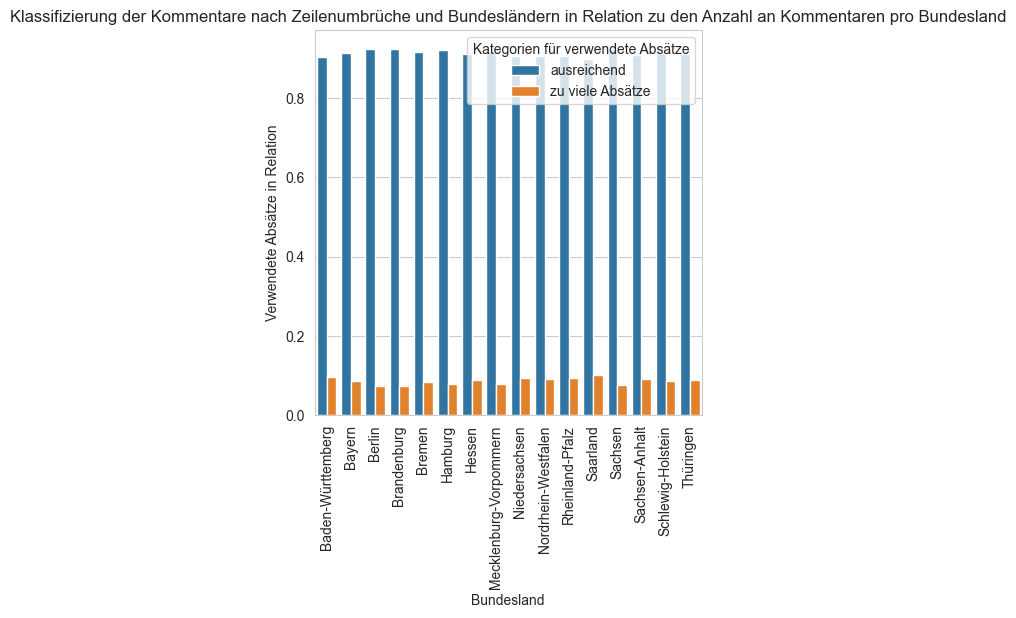

In [153]:
x=sns.barplot(data=bewertung_bundesland_graph2, x="Bundesland", y="Verwendete Absätze in Relation", hue="Kategorien für verwendete Absätze").set(title="Klassifizierung der Kommentare nach Zeilenumbrüche und Bundesländern in Relation zu den Anzahl an Kommentaren pro Bundesland");
plt.xticks(rotation=90)
plt.gcf().set_size_inches(5, 5)

Bei Betrachtung der Graphen und der Werte unterscheiden sich die Werte um wenige Prozentpunkte, was auf keinen klaren Trend hinweist.
Das Vorgehen für die nachfolgenden Gruppierungen verläuft nach dem gleichen Muster.

#### Gruppierung nach Einwohnerzahlen
Für die Gruppierung nach Einwohnerzahlen werden die Dateneinträge nach Einwohnerzahlen-Kategorien geordnet.

In [168]:
bewertung_v7["Kategorien für verwendete Absätze"]=bewertung_v7["absätze_count_Cats"]

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_6246/3308915015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bewertung_v7["Kategorien für verwendete Absätze"]=bewertung_v7["absätze_count_Cats"]


In [169]:
bewertung_einwohner_graoh_abs=bewertung_v7.groupby(["kategorie_stadtgröße","Kategorien für verwendete Absätze"])["id_x"].count()
bewertung_einwohner_graoh_abs_v1=bewertung_einwohner_graoh_abs.reset_index()
sum_einwohner=bewertung_einwohner_graoh_abs_v1.groupby(["kategorie_stadtgröße"])["id_x"].sum()
sum_einwohner=sum_einwohner.reset_index()
bewertung_einwohner_graph2=bewertung_einwohner_graoh_abs_v1.merge(sum_einwohner, how="left", left_on="kategorie_stadtgröße", right_on="kategorie_stadtgröße")
bewertung_einwohner_graph2["Verwendete Absätze in Relation"]=bewertung_einwohner_graph2.id_x_x/bewertung_einwohner_graph2.id_x_y
bewertung_einwohner_graph2

,kategorie_stadtgröße,Kategorien für verwendete Absätze,id_x_x,id_x_y,Verwendete Absätze in Relation
0,150.000 – 500.000,ausreichend,111589,122274,0.912614
1,150.000 – 500.000,zu viele Absätze,10685,122274,0.087386
2,20.000 – 50.000,ausreichend,161928,178346,0.907943
3,20.000 – 50.000,zu viele Absätze,16418,178346,0.092057
4,50.000 – 150.000,ausreichend,106211,117134,0.906748
5,50.000 – 150.000,zu viele Absätze,10923,117134,0.093252
6,500.000 – 1.000.000,ausreichend,72657,79329,0.915895
7,500.000 – 1.000.000,zu viele Absätze,6672,79329,0.084105
8,<20.000,ausreichend,422354,462836,0.912535
9,<20.000,zu viele Absätze,40482,462836,0.087465


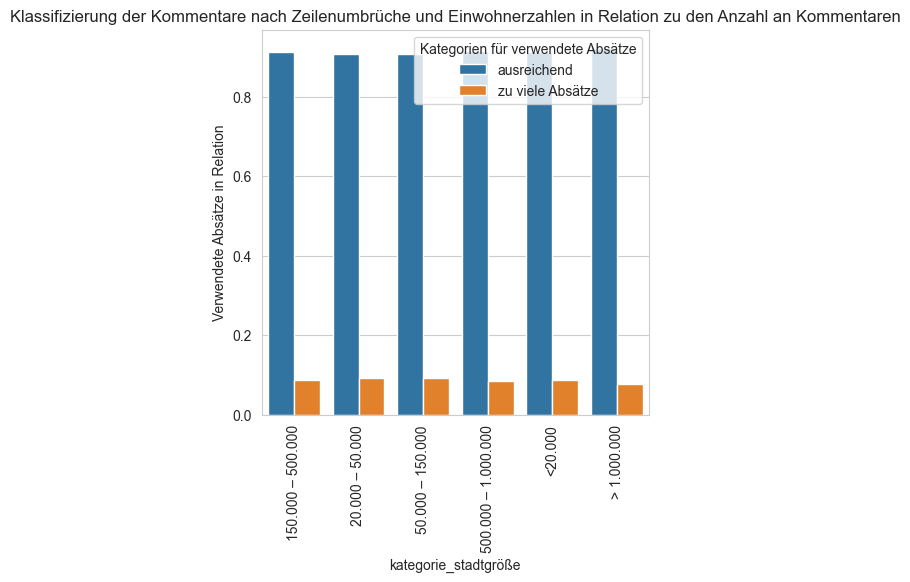

In [170]:
x=sns.barplot(data=bewertung_einwohner_graph2, x="kategorie_stadtgröße", y="Verwendete Absätze in Relation", hue="Kategorien für verwendete Absätze").set(title="Klassifizierung der Kommentare nach Zeilenumbrüche und Einwohnerzahlen in Relation zu den Anzahl an Kommentaren");
plt.xticks(rotation=90)
plt.gcf().set_size_inches(5, 5)

Bei Betrachtung der Werte und des Balkendiagramms sieht man auch hier keine klaren Tendenzen.

#### Gruppierung nach Altersgruppen
Für die Gruppierung nach Einwohnerzahlen werden die Dateneinträge nach Altersgruppen geordnet.

In [175]:
bewertung_altersgruppe_graph_abs=bewertung_v7.groupby(["altersgruppe","Kategorien für verwendete Absätze"])["id_x"].count()
bewertung_altersgruppe_graph_abs_v1=bewertung_altersgruppe_graph_abs.reset_index()
sum_altersgruppe=bewertung_altersgruppe_graph_abs_v1.groupby(["altersgruppe"])["id_x"].sum()
sum_altersgruppe=sum_altersgruppe.reset_index()
bewertung_altersgruppe_graph2=bewertung_altersgruppe_graph_abs_v1.merge(sum_altersgruppe, how="left", left_on="altersgruppe", right_on="altersgruppe")
bewertung_altersgruppe_graph2["Verwendete Absätze in Relation"]=bewertung_altersgruppe_graph2.id_x_x/bewertung_altersgruppe_graph2.id_x_y
bewertung_altersgruppe_graph2

,altersgruppe,Kategorien für verwendete Absätze,id_x_x,id_x_y,Verwendete Absätze in Relation
0,0.0-29.0,ausreichend,150877,165482,0.911743
1,0.0-29.0,zu viele Absätze,14605,165482,0.088257
2,30.0-50.0,ausreichend,433943,472018,0.919336
3,30.0-50.0,zu viele Absätze,38075,472018,0.080664
4,51.0-999.0,ausreichend,418332,461646,0.906175
5,51.0-999.0,zu viele Absätze,43314,461646,0.093825


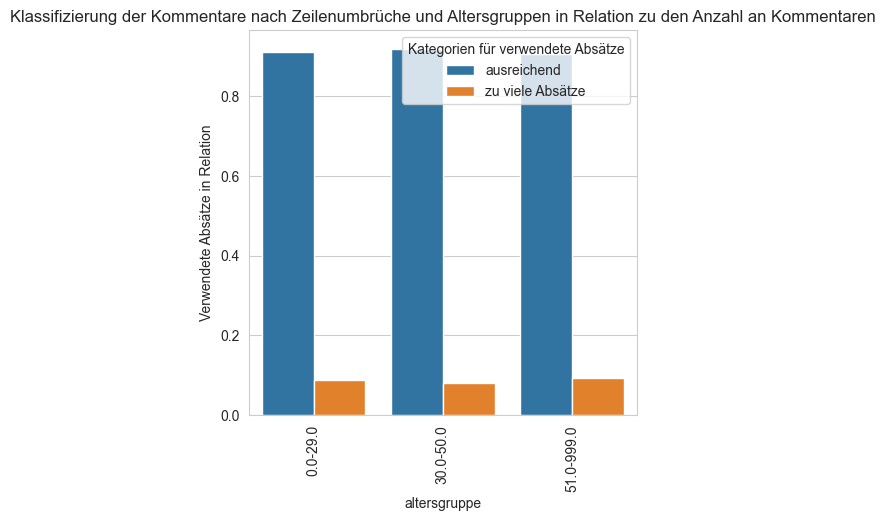

In [176]:
x=sns.barplot(data=bewertung_altersgruppe_graph2, x="altersgruppe", y="Verwendete Absätze in Relation", hue="Kategorien für verwendete Absätze").set(title="Klassifizierung der Kommentare nach Zeilenumbrüche und Altersgruppen in Relation zu den Anzahl an Kommentaren");
plt.xticks(rotation=90)
plt.gcf().set_size_inches(5, 5)

Und auch bei der Kategorisierung nach Altersgruppen sind keine klare Tendenzen zu erkennen.

### Satzzeichen (SpaCy)
Im Folgenden soll eine Analyse der Satzzeichen pro Zeichen Text durchgeführt werden. Somit können eventuelle Tendenzen im unterschiedlichen Umgang mit Zeichensetzung in unterschiedlichen Bevölkerungsgruppen herausgearbeitet werden.

Zunächst wurde diese Analyse mit der Python-Bibliothek spaCy durchgeführt, um auszutesten, wie diese funktioniert. Da hier allerdings für jedes Token eine Reihe an Analysen durchgeführt wird, ist zu erwarten, dass diese Implementierung deutlich langsamer ist als die zweite dieser Art, welche auf einem regulären Ausdruck beruht (siehe nächster Abschnitt).

Die Funktionsweise findet sich im Skript in Form von Kommentaren

In [8]:
# Ein Sample der Daten zur schnelleren Auswertung nehmen
local_sample = bewertungen.sample(10)

punct_count = []
punct_factor = []

# Tokenisierung jedes Bewertungstextes im Sample
for row in range(len(local_sample)):
  text = str(local_sample.iloc[row]["text"])
  doc = nlp(text)
  i = 0

  # Für jedes Token, welches 'PUNCT' (Punctuation) als typ hat, wird ein Zähler um eins erhöht
  for token in doc:
    if token.pos_ == 'PUNCT':
      i = i + 1

  # Das Ergebnis davon wird zwei Arrays hinzugefügt
  punct_count.append(i)
  punct_factor.append(i / len(text))

# Hinzufügen der Spalten für Anzahl und relative Anzahl an Satzzeichen zum DataFrame
local_sample["punctuation_count"] = punct_count
local_sample["punctuation_faktor"] = punct_factor

Eine Auswertung dieser Version der Analyse erfolgt hier nicht, da aufgrund des Rechenaufwandes, den die Benutzung von spaCy hier verursacht, keine annähernd ausreichende Datenmenge berechnet werden konnte.

### Satzzeichen (regex)

Da die Untersuchung mit spaCy durch die hohe Komplexität vergleichsweise sehr lange gedauert hat, wird im Folgenden die Analyse noch einmal unter Benutzung von regulären Ausdrücken durchgeführt. Das Vorgehen bleibt dabei ähnlich.

Der im Quelltext benutzte reguläre Ausdruck `[.:,;!?"]{1}` sagt dabei aus, dass alle einmaligen (`{1}`) Vorkommnisse der Satzzeichen `[.:,;!?"]` extrahiert werden soll.

In [9]:
# Speichern der Bewertungen in lokale Variable
local_sample = bewertungen

# Hilfs-Arrays
arr_count = []
arr_factor = []

# Schleife über alle Bewertungstexte
for i in range(len(local_sample)):
    # Text als String aus DataFrame nehmen
    text_str = local_sample.iloc[i][10]
    # Extraktion aller Satzzeichen, Zählen der Länge des Ergebnisses
    occurences = len(re.findall('[.:,;!?"]{1}', text_str))

    arr_count.append(occurences)
    arr_factor.append(occurences / len(text_str))

# Arrays zu Dataframe hinzufügen
local_sample["count_punctuation"] = arr_count
local_sample["factor_punctuation"] = arr_factor

# Erweiterungen der Daten zur Analyse nach Bundesland und Einwohnerzahl
local_sample = enrich_with_gebiet(local_sample)
local_sample = enrich_with_einwohnerzahl(local_sample)

#### Gruppiert nach Alter

Nun soll nach Altersgruppen gruppiert werden. Da hier noch ein leicht anderer Datensatz als früher im Dokument verwendet wird, muss der Datensatz zunächst um die Altersgruppen ergänzt werden.
Danach erfolgt eine Gruppierung nach diesen Kategorien, wobei aus den anderen Felder der Durchschnitt errechnet wird. Zuletzt wird das Ergebnis als Säulendiagramm dargestellt

[Text(0.5, 0, 'Altersgruppe'), Text(0, 0.5, 'Satzzeichen pro Zeichen Text')]

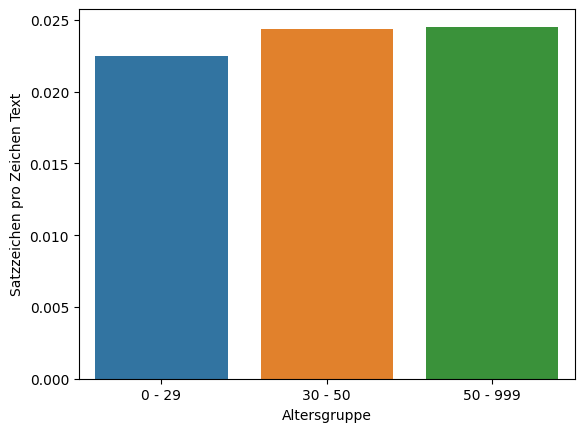

In [10]:
local_sample["alter_min"] = local_sample["alter_min"].replace({0.0: "0 - 29", 30.0: "30 - 50", 51.0: "50 - 999"})
data = local_sample[["alter_min", "alter_max", "count_punctuation", "factor_punctuation"]].groupby(by="alter_min").mean()
sns.barplot(x=data.index, y=data["factor_punctuation"]).set(xlabel='Altersgruppe', ylabel='Satzzeichen pro Zeichen Text')

Es lässt sich also sagen, dass jüngere Menschen unter 30 weniger Satzzeichen in Relation zur Länge des Textes verwenden als Menschen über 30.

#### Gruppiert nach Bundesland

Ähnlich wie bei den Altersgruppen wird hier nach den Bundesländern gruppiert, der Durchschnitt errechnet und das Ergebnis dargestellt

[Text(0.5, 0, 'Satzzeichen pro Zeichen Text'), Text(0, 0.5, 'Bundesland')]

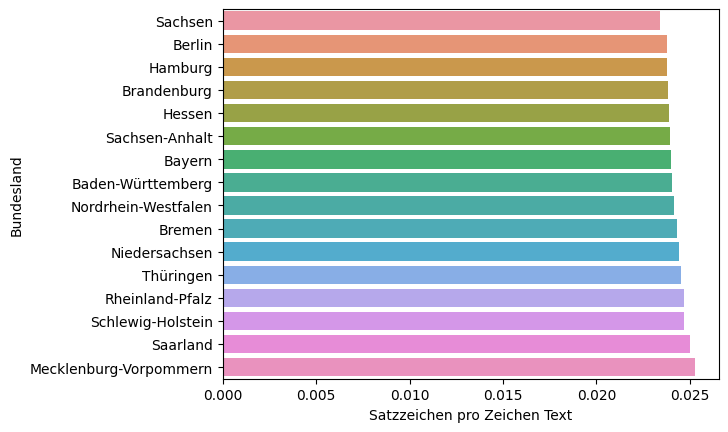

In [14]:
data = local_sample[["Bundesland", "count_punctuation", "factor_punctuation"]].groupby(by="Bundesland").mean().sort_values(by="factor_punctuation")
sns.barplot(y=data.index, x=data["factor_punctuation"]).set(xlabel='Satzzeichen pro Zeichen Text', ylabel='Bundesland')

Auch hier ist eine Tendenz zu erkennen. Allerdings lassen sich schwierig direkte Schlussfolgerungen daraus ziehen, eventuell hängt dies ebenfalls mit dem Alter der Bevölkerung zusammen

#### Gruppiert nach Gebiet
Das Vorgehen ähnelt erneut den vorherigen beiden Analysen. Hier wird nach dem dritten Analyseparameter, dem *Gebiet* (Ost- oder Westdeutschland), gruppiert.

[Text(0, 0.5, 'Gebiet'), Text(0.5, 0, 'Satzzeichen pro Zeichen Text')]

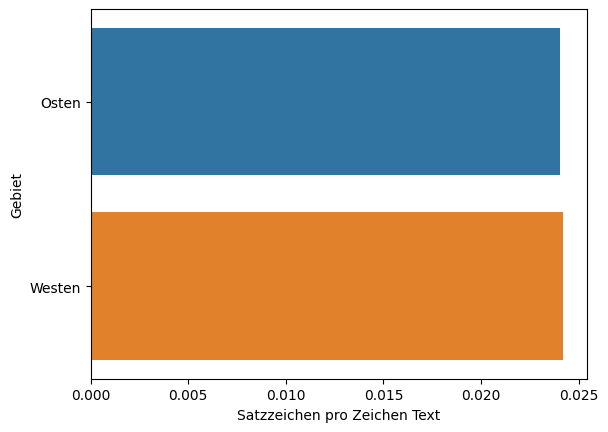

In [15]:
data = local_sample[["Gebiet", "count_punctuation", "factor_punctuation"]].groupby(by="Gebiet").mean()
sns.barplot(y=data.index, x=data["factor_punctuation"]).set(ylabel='Gebiet', xlabel='Satzzeichen pro Zeichen Text')

Auch hier lässt sich keine klare Tendenz erkennen.

#### Gruppiert nach Einwohnerzahl
Die letzte Analysekategorie stellt die Einwohnerzahl der Gemeinde dar. Hierzu wurden die Städtenamen der Standorte der Arztpraxen im Vorfeld um die jeweiligen Einwohnerzahlen ergänzt und in Kategorien ausgewertet.

Allerdings liegt bei diesen Daten die folgende Unschärfe vor. Wie schon erwähnt, wurde die Zuordnung Stadt <-> Einwohnerzahl hier über den Städtenamen getätigt. Hier kann es allerdings zu Verwechslungen kommen, falls es Städte gibt, die denselben Namen haben. Dies ist bei der Betrachtung und Bewertung dieser Daten im Hinterkopf zu behalten.

[Text(0, 0.5, 'Stadtgröße'), Text(0.5, 0, 'Satzzeichen pro Zeichen Text')]

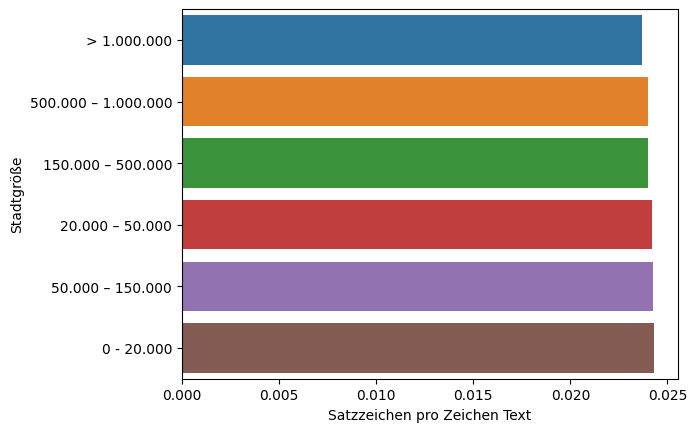

In [16]:
data = local_sample[["kategorie", "count_punctuation", "factor_punctuation"]].groupby(by="kategorie").mean().sort_values(by="factor_punctuation")
sns.barplot(y=data.index, x=data["factor_punctuation"]).set(ylabel='Stadtgröße', xlabel='Satzzeichen pro Zeichen Text')

Die einzige, minimale Tendenz ist bei den Millionenstädten zu erkennen. Auch hier wäre es möglich, dies mit der höchstwahrscheinlich jüngeren Bevölkerung zu begründen.

### Rechtschreibkorrektur

Als nächste Analyseform sollte die Anzahl der getätigten Rechtschreibfehler untersucht werden. Hierzu wurde zuerst versucht, mit einem Transformer von der Website huggingface.co (`oliverguhr/spelling-correction-german-base`), die Texte korrigieren zu lassen, um dann in einem zweiten Schritt die Differenzen zwischen der originalen und der korrigierten Version zu ermitteln.

Im Folgenden wird beispielhaft ein Text vom Modell korrigiert.

In [19]:
sample_spelling = bewertungen.sample(1)

# fix spelling of text
fix_spelling = pipeline("text2text-generation",model="oliverguhr/spelling-correction-german-base")
print("Original:")
print(sample_spelling.iloc[0]["text"])
print("----------------------------------------------------")
print("Korrigierte Version des Sprachmodells:")
fix_spelling(sample_spelling.iloc[0]["text"],max_length=2048)[0]["generated_text"]

Original:
Diese Ärztin hat nach einem dreiviertel Jahr, in der ich ihre Patientin war, die Behandlung ohne Erklärung

abgebrochen und auf meine mehrfache telefonische Nachfrage nicht reagiert. Leider hat mir die Behandlung nicht in gewünschter Weise geholfen, da ich keine konkreten Hilfestellungen bekommen habe, sondern die Therapie eher daran bestand mich mitzuteilen. Nach Ablauf der genehmigten Stunden wollte sie mich benachrichtigen, wenn meine Kasse die Verlängerung genehmigt hat. Diese Verlängerung wurde bei meiner Krankenkasse nie eingereicht. Ich hätte mir mindestens gewünscht, dass sie mich informiert und mir alternative Möglichkeiten nennt. Für dieses Verhalten habe ich kein Verständnis und auch keine Erklärung.
----------------------------------------------------
Korrigierte Version des Sprachmodells:


'Diese Ärztin hat nach einem dreiviertel Jahr, in der ich ihre Patientin war, um die Behandlung ohne Erklärung Highly Highly atabgebrochen und auf meine mehrfache telefonische Nachfrage nicht reagiert. Leider hat mir die Be Handlung nicht in gewünschter Weise geholfen, da ich keine konkreten Hilfestellungen bekommen habe, sondern die Therapie eher daran bestand, mich mitzuteilen. Nach Ablauf der genehmigten Stellung wollte sie die damals schon populäre Sängerin Eva Pilarov ersetzen, die zwischen 1962 und 1964 einen Gastauftritt im Theater Rokoko hatte.'

Hier lässt sich schnell erkennen, dass das Modell den Text stark abändert und auch neue Fehler einbaut. Scheinbar scheint es ein Problem mit der Länge des Textes zu geben, da diese Probleme immer nur nach ein paar Sätzen auftauchen. Somit wurde diese Möglichkeit nicht weiter betrachtet.

### Spellchecker

Somit musste nach einer neuen Vorgehensweise gesucht werden. Diese bildete die Python Bibliothek `spellchecker`, welche jedes Wort mit einem Wörterbuch abgleicht, um so Fehler zu entdecken.

In [20]:


# Laden der Bibliothek mit dt. Wörterbuch
spell = SpellChecker(language='de', distance=4)

# Extraktion eines Samples der Daten
text = bewertungen.sample(5000)

arr = []

# Schleife über alle Texte
for i in text["text"]:

    # Analyse der Daten
    # 1. Extraktion aller Wörter über regex
    # 2. Suchen aller unbekannten Wörter
    # 3. Zählen der unbekannten Wörter
    # 4. Ergebnis (Integer) zum Array hinzufügen
    arr.append(len(spell.unknown(re.findall("[a-zA-Züäöß]+", i))))

# befülltes Array als neue Spalte in DataFrame einfügen
text["count_spelling_mistakes"] = arr

# Aggregation nach bspw. Altersgruppen
text[["alter_min", "count_spelling_mistakes"]].groupby(by="alter_min").mean().sort_values(by="count_spelling_mistakes")

,count_spelling_mistakes
alter_min,
51.0,8.322549
30.0,9.210478
0.0,9.489415


In hier nicht dokumentierten ersten Tests, lieferte diese Bibliothek aber ungenauere Ergebnisse als die im Folgenden beschriebene Enchant (`pyenchant`), weswegen diese für die weitere

### Enchant

Das Vorgehen bei Enchant ist dasselbe wie im vorherigen Versuch mit SpellChecker. Zusätzlich werden einige, immer wieder fälschlicherweise als falsch erkannte, fachspezifische Begriffe händisch auf eine Art "Whitelist" gesetzt, um diese nicht als Fehler zu erkennen.

Trotzdem ist die Erkennung nicht hunderprozentig zuverlässig, das heißt die Ergebnisse können weiterhin Fehler beinhalten, was die Qualität der Ergebnisse beeinträchtigt.

In [21]:

# Laden des Wörterbuches
d = enchant.Dict("de_DE")

# Lokale Kopie des Bewertungen-Objektes
local_sample = bewertungen

# Whitelist für ganze Wörter
whitelist_words = [
    'Dr',
    'med',
    'ca',
    'etc',
    'usw'
]
# Whitelist für Wortbestandteile
whitelist_endings = [
    'logie',
    'logien',
    'ose',
    'osen',
    'nomie',
    'nomien',
    'tomie',
    'tomien',
    'pathie',
    'pathien',
    'ung',
    'tik',
    'kopie',
    'liche'
]

# Wrapper um die 'check'-Funktion der Bibliothek, um die Whitelist-Begriffe zu filtern.
def check_word(word, additional_whitelist):
    if word in whitelist_words:
        return True
    if word in additional_whitelist:
        return True
    for entry in whitelist_endings:
        if word.endswith(entry):
            return True
    return d.check(word)

arr = []

# Schleife über alle Zeilen
for i in range(len(local_sample)):
    count = 0
    # Text aus DataFrame extrahieren
    text_str = local_sample["text"].iloc[i]
    # Zusätzliche Whitelist mit dem Namen des Arztes
    local_whitelist = [local_sample["vorname"].iloc[i], local_sample["nachname"].iloc[i]]
    # Alle Wörter über einen regulären Ausdruck extrahieren
    words = re.findall("[A-ZÄÖÜ]?[a-züäöß]+", text_str)
    # Alle Wörter prüfen
    for word in words:
        if not(check_word(word, local_whitelist)):
            count = count + 1
    arr.append(count)

# Array zu DataFrame hinzufügen
local_sample["count_spelling_mistakes"] = arr

# Relative Anzahl zur Textlänge
local_sample["factor_spelling_mistakes"] = local_sample["count_spelling_mistakes"] / len(local_sample["text"])

# Hilfsfunktionen / Erweiterung
local_sample = enrich_with_einwohnerzahl(local_sample)
local_sample = enrich_with_gebiet(local_sample)

Das Vorgehen in der Auswertung der Analyse ist nun analog zu den Vorgehensweisen bei der Untersuchung der Satzeichen.

#### Gruppiert nach Alter

[Text(0, 0.5, 'Fehlerquote'), Text(0.5, 0, 'Altersgruppen')]

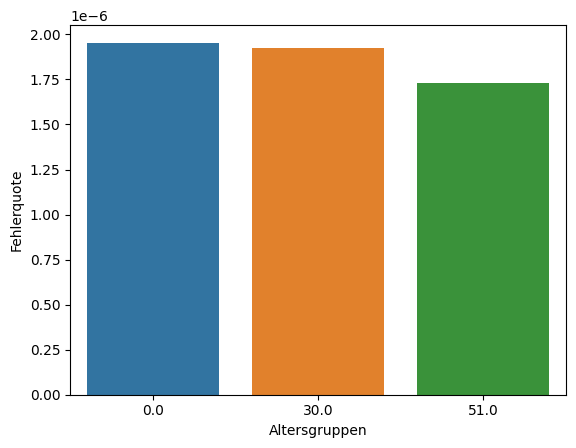

In [29]:
data = local_sample[["alter_min", "factor_spelling_mistakes", "count_spelling_mistakes"]].groupby(by="alter_min").mean()
sns.barplot(x=data.index, y=data.factor_spelling_mistakes).set(ylabel="Fehlerquote", xlabel="Altersgruppen")

Somit scheinen ältere Menschen weniger Rechtschreibfehler als jüngere zu machen.

#### Gruppiert nach Bundesland

<AxesSubplot: xlabel='factor_spelling_mistakes', ylabel='Bundesland'>

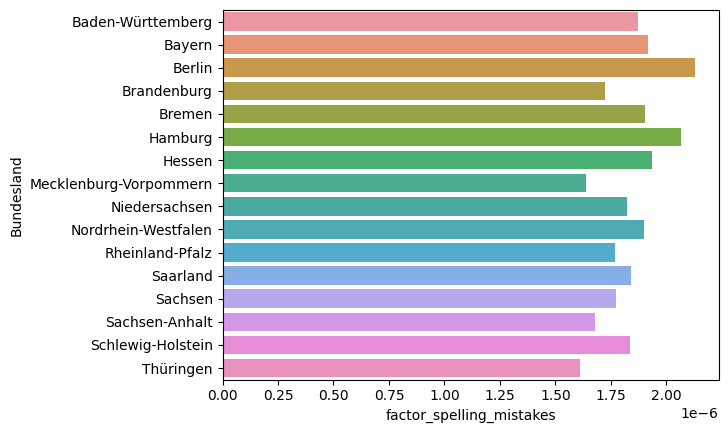

In [31]:
data = local_sample[["Bundesland", "factor_spelling_mistakes", "count_spelling_mistakes"]].groupby(by="Bundesland").mean()
sns.barplot(x=data.factor_spelling_mistakes, y=data.index)

Auch hier lässt sich wieder kein klares Muster erkennen. Eventuell hängen die hohen Fehlerquoten in Hamburg und Berlin erneut mit der tendenziell jüngeren Bevölkerung zusammen.

#### Gruppiert nach Gebiet

<AxesSubplot: xlabel='factor_spelling_mistakes', ylabel='Gebiet'>

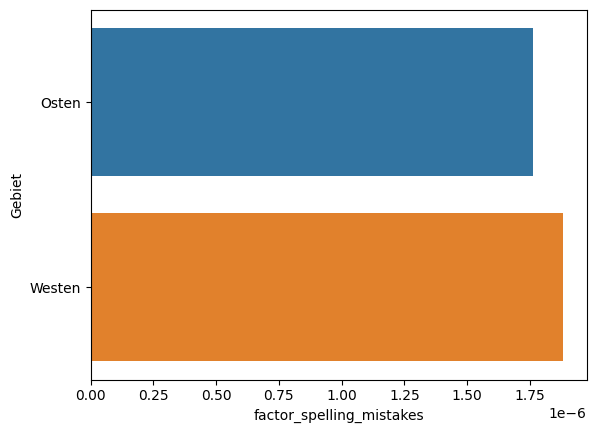

In [32]:
data = local_sample[["Gebiet", "factor_spelling_mistakes", "count_spelling_mistakes"]].groupby(by="Gebiet").mean()
sns.barplot(y=data.index, x=data["factor_spelling_mistakes"])

Hier lässt sich sehen, dass Bewertungen im Westen mit einer tendenziell höheren Fehlerquote geschrieben werden.

#### Gruppiert nach Einwohnerzahl

<AxesSubplot: xlabel='factor_spelling_mistakes', ylabel='kategorie'>

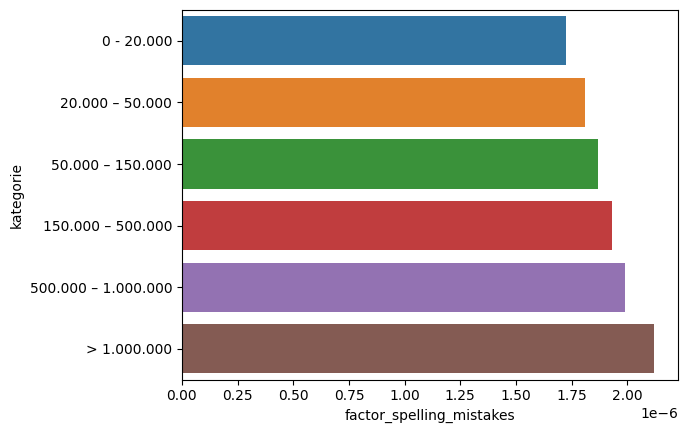

In [33]:
data = local_sample[["kategorie", "factor_spelling_mistakes", "count_spelling_mistakes"]].groupby(by="kategorie").mean().sort_values("factor_spelling_mistakes")
sns.barplot(y=data.index, x=data["factor_spelling_mistakes"])

Ähnlich wie bei der Textlänge lässt sich ein deutlicher Zusammenhang zwischen steigender Einwohnerzahl und steigender Fehlerquote erkennen. Wenn davon auszugehen ist, dass in Großstädten mehr junge Menschen leben, passt dies mit dem Ergebnis der Analyse der Altersgruppen überein.

### Text-Länge

Zur Untersuchung der Text-Länge wurde eine neue Spalte zum DataFrame hinzugefügt, welche die Länge des jeweiligen Text-Strings enthält

In [34]:
local_sample = bewertungen

local_sample["Länge Text"] = local_sample["text"].str.len()

local_sample = enrich_with_einwohnerzahl(enrich_with_gebiet(local_sample))

Bei der Analyse dieser Daten ließen sich deutliche Unterschiede erkennen.

#### Gruppiert nach Altersklasse

<AxesSubplot: xlabel='Alter größer', ylabel='Länge Text'>

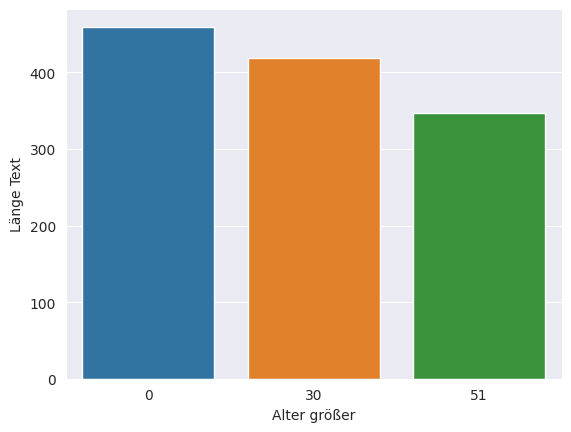

In [74]:
local_sample["Alter größer"] = local_sample["alter_min"].astype(np.int8)
data = local_sample[["Alter größer", "alter_max", "Länge Text"]].groupby(by="Alter größer").mean()
sns.barplot(x=data.index, y=data["Länge Text"])

#### Gruppiert nach Bundesland

<AxesSubplot: xlabel='Text-Länge', ylabel='Bundesland'>

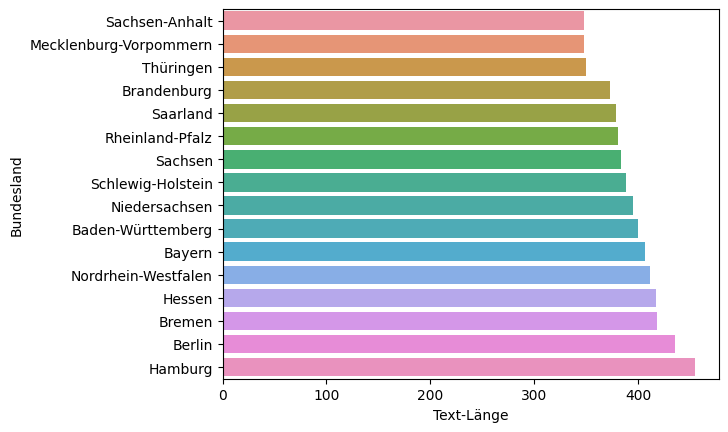

In [24]:
data = local_sample[["Bundesland", "Länge Text"]].groupby(by="Bundesland").mean().sort_values(by="Länge Text")
fig = sns.barplot(y=data.index, x=data["Länge Text"])
fig.set(xlabel='Text-Länge', ylabel='Bundesland')
fig

#### Gruppiert nach Ost-West

<AxesSubplot: xlabel='Länge Text', ylabel='Gebiet'>

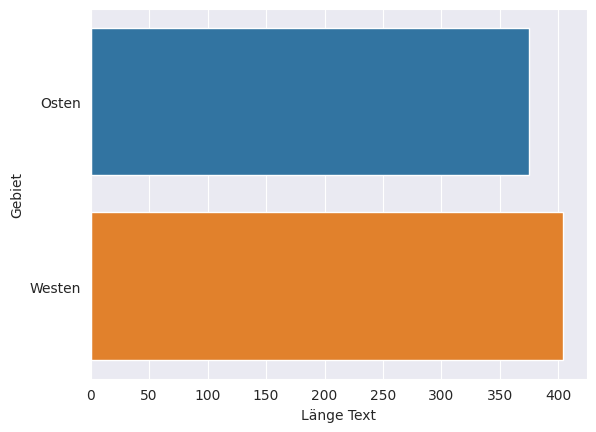

In [63]:
data = local_sample[["Gebiet", "Länge Text"]].groupby(by="Gebiet").mean()
sns.barplot(x=data["Länge Text"], y=data.index)

#### Gruppiert nach Einwohnerzahl

[Text(0.5, 0, 'Text-Länge (in Zeichen)'), Text(0, 0.5, 'Einwohnerzahl')]

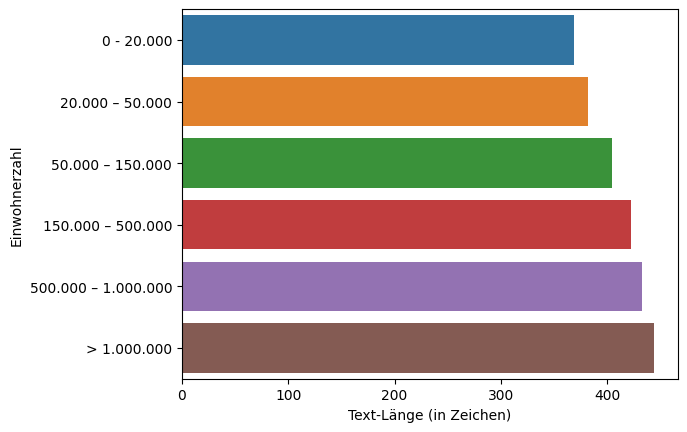

In [31]:
data = local_sample[["kategorie", "Länge Text"]].groupby(by="kategorie").mean().sort_values("Länge Text")
sns.barplot(x=data["Länge Text"], y=data.index).set(xlabel='Text-Länge (in Zeichen)', ylabel='Einwohnerzahl')

Mit steigendem Alter sinkt die Länge des Textes, andersrum steigt diese mit steigender Stadtgröße. Somit scheinen jüngere und urban lebende Menschen längere Texte für die Bewertung eines Arztes zu verfassen.

### Anzahl Großbuchstaben

Eine weitere Idee war die Untersuchung der Groß- und Kleinschreibung der Texte. Hierzu wurden diese über einen regulären Ausdruck extrahiert und gezählt.
Zudem wurde eine Analyse der absoluten Zahlen der Buchstaben durchgeführt.

In [36]:
local_sample = bewertungen

arr_count_buchstaben = []
arr_count_großbuchstaben = []

# Schleife über alle Zeilen
for i in range(len(local_sample)):
    text_str = local_sample.iloc[i][10]
    # Zählen der Buchstaben des Textes und Hinzufügen zu Array
    count_buchstaben = len(re.findall('[a-zA-ZäöüßÜÖÄ]{1}', text_str))
    if count_buchstaben == 0:
        count_buchstaben = 1
    arr_count_buchstaben.append(count_buchstaben)
    # Zählen der Großbuchstaben des Textes
    arr_count_großbuchstaben.append(len(re.findall('[A-Z]{1}', text_str)))

local_sample["anzahl_buchstaben"] = arr_count_buchstaben
local_sample["anzahl_großbuchstaben"] = arr_count_großbuchstaben
# Neue Spalte für das Verhältnis zwischen Groß- und Kleinbuchstaben
local_sample["faktor_großbuchstaben"] = local_sample["anzahl_großbuchstaben"] / local_sample["anzahl_buchstaben"]
local_sample = enrich_with_gebiet(local_sample)
local_sample = enrich_with_einwohnerzahl(local_sample)

#### Gruppiert nach Altersklasse
Gesamtzahl Buchstaben

<AxesSubplot: xlabel='Alter größer', ylabel='Anzahl Buchstaben'>

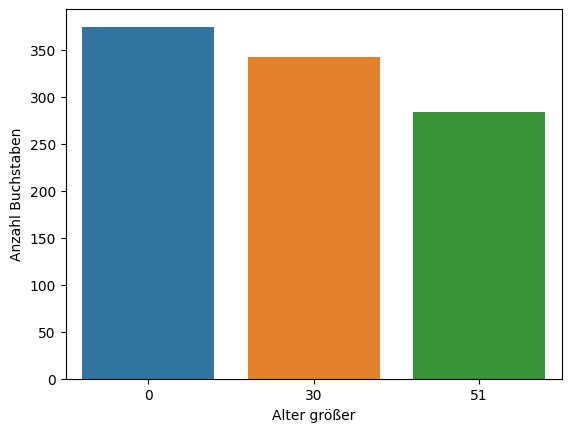

In [37]:
local_sample["Alter größer"] = local_sample["alter_min"].astype(np.int8)
local_sample["Anzahl Buchstaben"] = local_sample["anzahl_buchstaben"]

data = local_sample[["Alter größer", "alter_max", "Anzahl Buchstaben", "anzahl_großbuchstaben", "faktor_großbuchstaben"]].groupby(by="Alter größer").mean().sort_values("Anzahl Buchstaben")
sns.barplot(y=data["Anzahl Buchstaben"], x=data.index)

Relative Anzahl Großbuchstaben

<AxesSubplot: xlabel='Alter größer', ylabel='Faktor Großbuchstaben'>

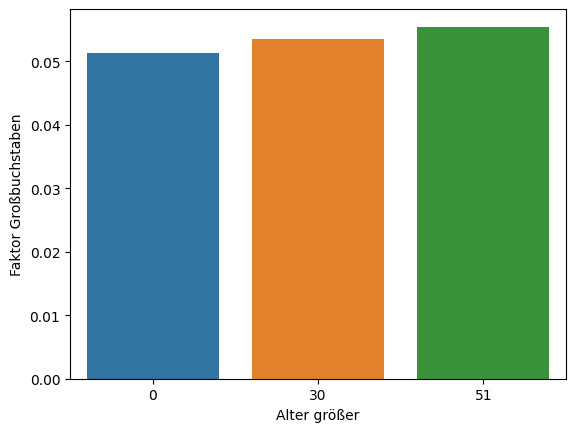

In [38]:
local_sample["Alter größer"] = local_sample["alter_min"].astype(np.int8)
local_sample["Faktor Großbuchstaben"] = local_sample["faktor_großbuchstaben"]

data = local_sample[["Alter größer", "alter_max", "Anzahl Buchstaben", "anzahl_großbuchstaben", "Faktor Großbuchstaben"]].groupby(by="Alter größer").mean()
sns.barplot(y=data["Faktor Großbuchstaben"], x=data.index)

#### Gruppiert nach Bundesland
Absolute Anzahl Buchstaben

<AxesSubplot: xlabel='anzahl_buchstaben', ylabel='Bundesland'>

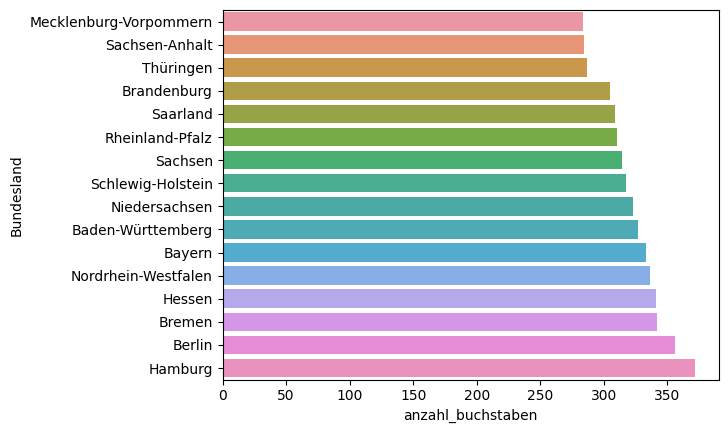

In [39]:
data = local_sample[["Bundesland", "anzahl_buchstaben", "anzahl_großbuchstaben", "faktor_großbuchstaben"]].groupby(by="Bundesland").mean().sort_values(by="anzahl_buchstaben")
sns.barplot(x=data["anzahl_buchstaben"], y=data.index)

Relative Anzahl Großbuchstaben

<AxesSubplot: xlabel='faktor_großbuchstaben', ylabel='Bundesland'>

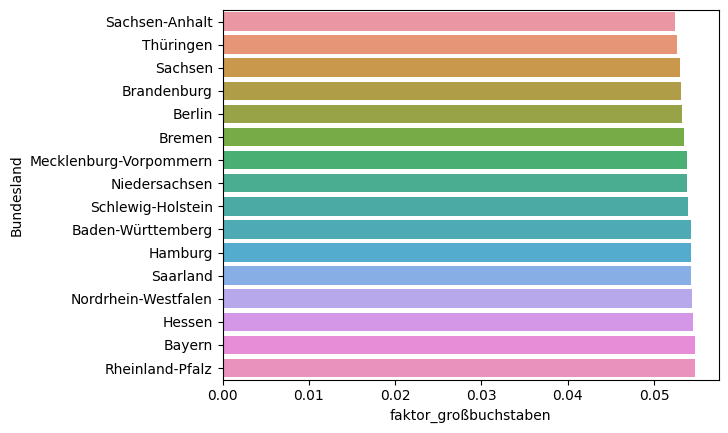

In [40]:
data = local_sample[["Bundesland", "anzahl_buchstaben", "anzahl_großbuchstaben", "faktor_großbuchstaben"]].groupby(by="Bundesland").mean().sort_values(by="faktor_großbuchstaben")
sns.barplot(x=data["faktor_großbuchstaben"], y=data.index)

#### Gruppiert nach Gebiet
Absolute Anzahl Buchstaben

<AxesSubplot: xlabel='anzahl_buchstaben', ylabel='Gebiet'>

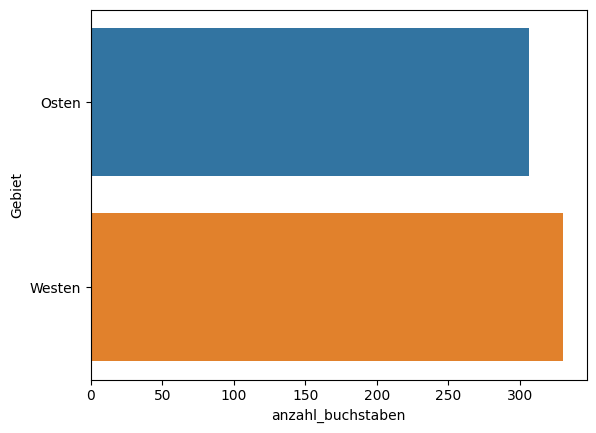

In [41]:
data = local_sample[["Gebiet", "anzahl_buchstaben", "anzahl_großbuchstaben", "faktor_großbuchstaben"]].groupby(by="Gebiet", ).mean()
sns.barplot(y=data.index, x=data.anzahl_buchstaben)

Relative Anzahl Großbuchstaben

[Text(0.5, 0, 'Faktor Großbuchstaben')]

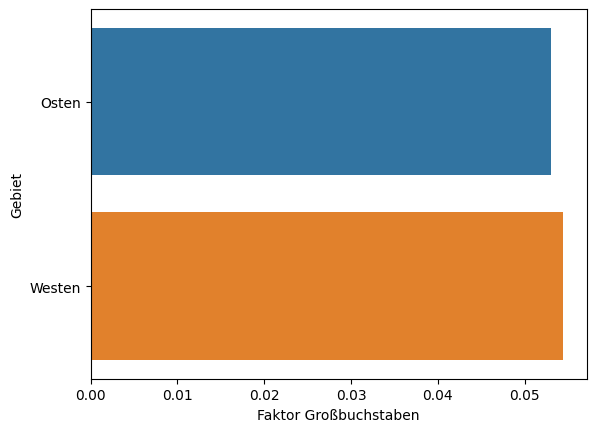

In [43]:
grouped_by_gebiet = local_sample[["Gebiet", "anzahl_buchstaben", "anzahl_großbuchstaben", "faktor_großbuchstaben"]].groupby(by="Gebiet", ).mean().sort_values("faktor_großbuchstaben")
sns.barplot(y=grouped_by_gebiet.index, x=grouped_by_gebiet.faktor_großbuchstaben).set(xlabel="Faktor Großbuchstaben")

#### Gruppiert nach Einwohnerzahl
Relative Anzahl Großbuchstaben

<AxesSubplot: xlabel='faktor_großbuchstaben', ylabel='kategorie'>

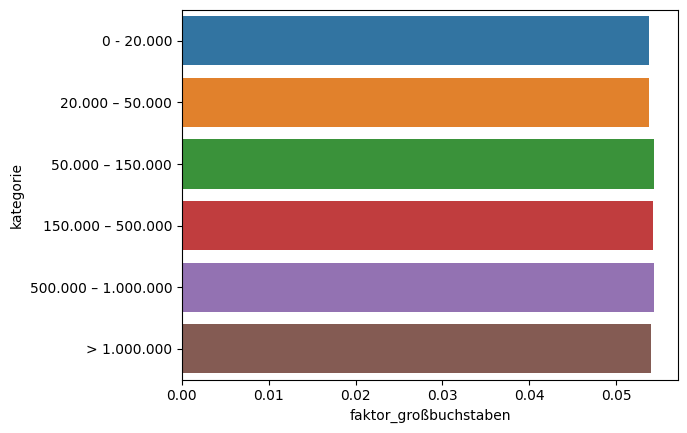

In [42]:
data = local_sample[["kategorie", "anzahl_buchstaben", "anzahl_großbuchstaben", "faktor_großbuchstaben"]].groupby(by="kategorie").mean().sort_values(by="anzahl_buchstaben")
sns.barplot(y=data.index, x=data.faktor_großbuchstaben)

Die Analyse der absoluten Zahlen bestätigt die Analyse der Text-Länge aus dem vorherigen Schritt.

Bei der relativen Anzahl der Großbuchstaben lässt sich wieder ein deutlicher Unterschied bei den Altersgruppen erkennen. Mit steigendem Alter steigt auch diese Metrik. Bei Bundesland, Gebiet und Einwohnerzahl lassen sich auch leichte Unterschiede erkennen, diese sind aber minimal

---

## Weiterführende Ideen

### Sentiment Analysis

Eine weitere Idee war die Durchführung einer Sentimentanalyse, um auch hier eventuelle Auffälligkeiten herauszuarbeiten und zu aggregieren. Dafür wurde zunächst nach einer geeigneten Methode zur technischen Durchführung der Analyse gesucht. Somit sollte zuerst in einer kurzen Machbarkeitsstudie geprüft werden, ob zwei Modelle von huggingface.co für die Aufgabe generell geeignet wären und die Ergebnisse dieser verlässlich wären.

Somit wurden zufällig ausgewählte Bewertungstexte von den beiden Modellen analyisiert und die Ergebnisse daraus mit der tatsächlichen Bewertung und dem ursprünglichen Text manuell verglichen. Dabei viel allerdings auf, dass die Ergebnisse leider nicht die erhoffte Genauigkeit ergaben, sodass dieses Vorhaben daraufhin wieder verworfen wurde.
Zudem wurde bekannt, dass eine andere Gruppe des Kurses sich ausschließlich mit diesem Thema beschäftigt, was ebenfalls dafür sprach, dies an dieser Stelle nicht weiterzuverfolgen.

In [ ]:
# Initialisierung des Modells von nlptown
tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model_nlptown = BertForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Initialisierung des Modells von Oliver Guhr
model_guhr = SentimentModel()

# Erstellen eines Samples der Daten zu Testzwecken
local_sample = bewertungen.sample(1)

# Arrays für Befüllung im Loop
arr_sentiments_nlptown = []
arr_sentiments_guhr = []

# Loop über alle Zeilen des Samples
for i in range(len(local_sample)):

    # Extraktion des Textes aus DataFrame (bzw. der Series des Schleifen-Durchlaufs)
    data = local_sample.iloc[i][10]

    # Analyse der Daten mit dem Modell von nlptown, Code stammt von Website des Modells
    inputs = tokenizer(data, return_tensors="pt")

    with torch.no_grad():
        logits = model_nlptown(**inputs).logits

    predicted_class_id = logits.argmax().item()

    arr_sentiments_nlptown.append(model_nlptown.config.id2label[predicted_class_id])

    # Analyse der Daten mit dem Modell von Oliver Guhr, Code stammt von Website des Modells
    arr_sentiments_guhr.append(model_guhr.predict_sentiment(data))

# Einfügen der Arrays in DataFrame
local_sample["sentiment_nlptown"] = arr_sentiments_nlptown
local_sample["sentiment_guhr"] = arr_sentiments_guhr
local_sample["sentiment_guhr_new"] = model_guhr.predict_sentiment(local_sample["text"])

# Ausgabe der Ergebnisse
print(local_sample["text"])
local_sample[["note_gesamt", "sentiment_guhr_new", "sentiment_nlptown"]]

,note_gesamt,sentiment_guhr_new,sentiment_nlptown,text
99967,1.0,positive,5 stars,"Dieser Hausarzt ist der beste Arzt, den ich bi..."


# Fazit / Learnings

## Genaues Auseinandersetzen mit den Datenstrukturen

Wie zu Beginn des Kapitals **Datenqualität** erwähnt, ist das Fundament für eine Datenanalyse gescheite Datenaufbereitung. Hierfür war und ist es wichtig sich mit den Datensätze auseinanderzusetzen und mögliche Komplikationen weitestgehend zu minimieren.

## Auswahl der Tools ist wichtig

Am Deutlichsten wurde dies bei der Umsetzung der Satzzeichen-Analyse mit spaCy. Das Tool war in diesem Fall zu komplex, um diese sehr simple Aufgabe zu erfüllen. Die Folge hiervon waren lange Ladezeiten und eine schlechte Performance. Die Umsetzung dessen über einen regulären Ausdruck hingegen funktionierte deutlich schneller und mit gleichem Ergebniss.
Ein anderes Beispiel ist die Rechtschreibkorrektur. Auch hier war das komplexeste der getesteten Werkzeuge nicht für die Aufgabe geeignet, hier allerdings aufgrund von fehlerhaften Ergebnissen. Durch Ausprobieren wurde sich dann für Enchant entschieden, da es nach Sichtung von Beispielen Out-of-the-Box bessere Ergebnisse lieferte als SpellChecker. Somit hat sich hier das Investieren zusätzlicher Zeit gelohnt.

## Probleme mit der Datenqualität

Wie in der Anmerkung zu Beginn des Dokumentes beschrieben, traten einige Probleme mit der Semantik der Daten auf. Bspw. gibt es keine Lösung für die Problematik Patient <-> Autor der Bewertung. Auch wenn diese Probleme nicht beseitigt werden können, kann  trotzdem mit ihnen fortgefahren werden, wenn sie das Ergebnis vorraussichtlich nur minimal verfälschen. Allerdings ist es dann wichtig, korrekterweise darauf hinzuweisen, dass diese Probleme bestehen und hingenommen werden